# Advanced line detection

## Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

%load_ext autoreload
%autoreload 2

from calibration import *
from pipeline import *
from helpers import *
from line import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

### Helper functions

Helpers function are defined in helpers.py file

### Load and display images for calibration:

In [ ]:
calibration_image_list = {}

for i,fileName in enumerate(os.listdir("camera_cal/")):
    image = mpimg.imread('camera_cal/' + fileName)
    calibration_image_list[fileName] = image
    
plot_images_map(calibration_image_list)

### Calibrate the camera

Show calibrated images, real calibration is in calibration.py

In [ ]:
undistored_images = {}

# undistort calibration images
for file_name in images_with_corners:
    image = mpimg.imread(file_name)        
    undistored_images[file_name] = cv2.undistort(image, mtx, dist, None, mtx) 

print("found ", len(images_with_corners), "image(s) with corners in ", len(calibration_image_list), "images and undistored ", len(undistored_images))    

### Show images with cornes

In [ ]:
plot_images_map(images_with_corners)

### Show undistored images 

In [ ]:
plot_images_map(undistored_images)

## Example of calibration

In [ ]:
# plot big images of "original" and "undistorted" for "camera_cal/calibration4.jpg"
image = mpimg.imread("camera_cal/calibration1.jpg")
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plot_images_map({"original" : image, "undistorted" : undistorted}, columns=2, img_size=(40, 110))


# Process test images

## Load and display images

In [ ]:
test_images = {}
undistorted_test_images = {}

for i,fileName in enumerate(os.listdir("test_images/")):
    image = mpimg.imread('test_images/' + fileName)
    test_images[fileName] = image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    test_images[fileName + "-undistorted"] = undistorted_image
    undistorted_test_images[fileName] = undistorted_image
    
plot_images_map(test_images, columns=2, img_size=(40, 110))

### HLS thresholding

In [ ]:
channels = {}
for file_name in undistorted_test_images :
    img = undistorted_test_images[file_name]
    channels[file_name + "original"] = img
    channels[file_name + "h"] = hls_select(img)
    channels[file_name + "l"] = hls_select(img, channel=1)
    channels[file_name + "s"] = hls_select(img, channel=2)

plot_images_map(channels, columns=4, img_size=(30, 50))

### Pipelines

#### videos

In [2]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")


#### Get frames from the videos for analysis

In [ ]:
for i in range(0,170):
    image = challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

for i in range(0,170):
    image = harder_challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/harder_challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
for i in range(0,170):
    image = project_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/project_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

#### test single image

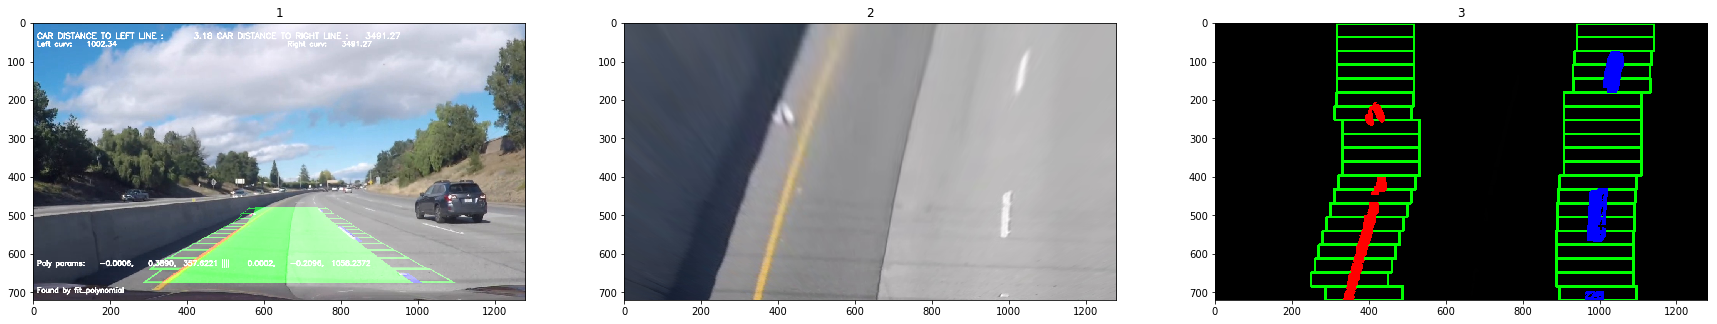

In [3]:
image = mpimg.imread('test_images_extra/challenge_video_11.jpg')
res = pipeline(image)
plot_images_map({"1":res[0], "2":res[1], "3":res[2] }, columns=3, img_size=(30, 50))

In [ ]:
S = hls_select(res[1], 2)
def channel_threshold(channel, min=120, max=255):
    binary = np.zeros_like(channel)
    binary[(channel > 100) & (channel <= 255)] = 1
    
    return binary

binary = channel_threshold(S)


def erode_and_dilate(binary):
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(binary,kernel,iterations = 1)

    kernel = np.ones((12,12),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 2)
    return dilation

# plot_images_map({"1":binary, "2":binary_output_sobel, "3": erode_and_dilate(binary_output_sobel)}, columns=3, img_size=(30, 50))

# # dilation[binary_output_sobel == 0] = 0
binary_output_sobelx = binary_output_sobel(res[1])
img1_bg = cv2.bitwise_and(res[1],res[1],mask = erode_and_dilate(binary_output_sobelx))

plt.imshow(binary_output_sobelx)



In [5]:
def process_image(image):
    return pipeline(image)[0]

In [6]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")

# Process videos

In [ ]:
challenge_video_clip = challenge_video.fl_image(process_image) 
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

In [7]:
harder_challenge_video_clip = harder_challenge_video.fl_image(process_image) 
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[-7.38449502e-04  7.69293823e-01  8.21336413e+02]
[MoviePy] >>>> Building video results/harder_challenge_video.mp4
[MoviePy] Writing video results/harder_challenge_video.mp4


  0%|          | 1/1200 [00:00<02:15,  8.86it/s]

[-7.38449502e-04  7.69293823e-01  8.21336413e+02]


  3%|▎         | 37/1200 [00:03<02:02,  9.51it/s]

[-6.53342999e-04  8.66105006e-01 -7.28045735e+01]
[-7.24645561e-04  9.36158456e-01 -8.45546984e+01]


  3%|▎         | 39/1200 [00:04<02:04,  9.32it/s]

[-8.25886393e-04  1.03338682e+00 -1.01054105e+02]
[-9.10737569e-04  1.12134988e+00 -1.18304259e+02]


  3%|▎         | 41/1200 [00:04<02:09,  8.92it/s]

[-9.88346477e-04  1.20435807e+00 -1.35454930e+02]
[-1.07591273e-03  1.30222598e+00 -1.57022581e+02]


  4%|▎         | 43/1200 [00:04<02:19,  8.31it/s]

[-1.12415076e-03  1.36175768e+00 -1.72668384e+02]
[-1.16024324e-03  1.40883285e+00 -1.86522455e+02]
[6.99671606e-05 8.06181855e-01 6.06295793e+02]


  4%|▍         | 45/1200 [00:04<02:26,  7.90it/s]

[-1.19923101e-03  1.46029497e+00 -2.01088532e+02]
[4.58023538e-05 8.37552232e-01 5.99067912e+02]
[-1.22513802e-03  1.50094760e+00 -2.14858788e+02]
[4.49589651e-05 8.64472289e-01 5.89461025e+02]


  4%|▍         | 47/1200 [00:05<02:28,  7.78it/s]

[-1.26931650e-03  1.56053382e+00 -2.32751563e+02]
[-2.89357657e-06  9.05497830e-01  5.78591001e+02]
[-1.29515075e-03  1.59857617e+00 -2.45820113e+02]
[-1.60800421e-05  9.20754003e-01  5.73290842e+02]


  4%|▍         | 49/1200 [00:05<02:31,  7.60it/s]

[-1.28961244e-03  1.60632329e+00 -2.50751469e+02]
[-2.90208675e-05  9.36922958e-01  5.67914013e+02]
[-1.29411505e-03  1.62387367e+00 -2.58747044e+02]
[3.27339033e-05 8.96823286e-01 5.71709265e+02]


  4%|▍         | 51/1200 [00:05<02:24,  7.93it/s]

[-1.29332924e-03  1.63713736e+00 -2.66231980e+02]
[8.42904310e-05 8.61513010e-01 5.75252962e+02]
[-1.25594311e-03  1.61333405e+00 -2.65725403e+02]


  4%|▍         | 53/1200 [00:05<02:23,  8.02it/s]

[-1.26962561e-03  1.63989168e+00 -2.75042260e+02]
[5.17949894e-05 8.80746921e-01 5.76329635e+02]
[-1.26425862e-03  1.65175673e+00 -2.82620285e+02]
[2.65664681e-05 9.09935334e-01 5.69105872e+02]


  5%|▍         | 55/1200 [00:06<02:22,  8.05it/s]

[-1.26180000e-03  1.66835489e+00 -2.92160143e+02]
[-3.02114914e-05  9.67022976e-01  5.57043743e+02]
[-1.27389602e-03  1.70026267e+00 -3.05448284e+02]
[-7.92798530e-05  1.00567654e+00  5.51612801e+02]


  5%|▍         | 57/1200 [00:06<02:21,  8.09it/s]

[-1.33862439e-03  1.77831903e+00 -3.27324769e+02]
[-4.20929188e-05  9.91680719e-01  5.45491088e+02]
[-1.35651513e-03  1.81700836e+00 -3.42036983e+02]
[-2.61738360e-05  1.00180967e+00  5.35810900e+02]


  5%|▍         | 59/1200 [00:06<02:21,  8.06it/s]

[-1.36182347e-03  1.83951800e+00 -3.52326405e+02]
[-5.07235049e-05  1.03105672e+00  5.27058720e+02]
[-1.32802573e-03  1.81462558e+00 -3.50258119e+02]
[-5.27523861e-06  9.81407720e-01  5.40672724e+02]


  5%|▌         | 61/1200 [00:06<02:20,  8.12it/s]

[-1.32561627e-03  1.82943261e+00 -3.59024733e+02]
[3.08755862e-05 9.61908243e-01 5.39727570e+02]
[-1.30541107e-03  1.82421406e+00 -3.62868615e+02]
[3.44445165e-05 9.45860328e-01 5.49584925e+02]


  5%|▌         | 63/1200 [00:07<02:20,  8.10it/s]

[-1.33711795e-03  1.87461757e+00 -3.80058204e+02]
[3.41031050e-05 9.48562931e-01 5.44498224e+02]
[-1.32818173e-03  1.88196138e+00 -3.86536325e+02]
[2.71069522e-05 9.53105510e-01 5.42021076e+02]


  5%|▌         | 65/1200 [00:07<02:21,  8.03it/s]

[-1.38269383e-03  1.95683558e+00 -4.09834499e+02]
[-2.10436083e-05  1.01397361e+00  5.19539639e+02]
[-1.44361296e-03  2.04226783e+00 -4.37178166e+02]
[-6.22817815e-05  1.06682714e+00  5.00613129e+02]


  6%|▌         | 67/1200 [00:07<02:20,  8.04it/s]

[-1.48516576e-03  2.09562166e+00 -4.54779982e+02]
[-1.09238816e-04  1.12036228e+00  4.85465647e+02]
[-1.46466798e-03  2.09755758e+00 -4.62442040e+02]
[-1.74013579e-04  1.19827519e+00  4.65675316e+02]


  6%|▌         | 69/1200 [00:07<02:19,  8.11it/s]

[-1.48901456e-03  2.14123039e+00 -4.79611105e+02]
[-2.77103232e-04  1.29957170e+00  4.42280990e+02]
[-1.52467638e-03  2.19745963e+00 -4.99965209e+02]
[-3.48993476e-04  1.40147572e+00  4.10788898e+02]


  6%|▌         | 71/1200 [00:08<02:18,  8.12it/s]

[-1.73987385e-03  2.41172226e+00 -5.53684741e+02]
[-3.37045743e-04  1.40424343e+00  4.07075150e+02]
[-1.73884302e-03  2.42062444e+00 -5.60980687e+02]
[-2.93287065e-04  1.36853476e+00  4.13100022e+02]


  6%|▌         | 73/1200 [00:08<02:18,  8.12it/s]

[-1.58109187e-03  2.27536528e+00 -5.31627654e+02]
[-2.12897487e-04  1.28274424e+00  4.31093792e+02]
[-1.38458536e-03  2.10517098e+00 -4.98700574e+02]
[-1.95239940e-04  1.27475977e+00  4.31079155e+02]


  6%|▋         | 75/1200 [00:08<02:19,  8.04it/s]

[-1.36148068e-03  2.09757937e+00 -5.03365491e+02]
[-1.28410050e-04  1.22454443e+00  4.39298388e+02]
[-1.20113812e-03  1.94439929e+00 -4.72121954e+02]
[6.81938755e-05 1.06935702e+00 4.64849461e+02]


  6%|▋         | 77/1200 [00:08<02:18,  8.11it/s]

[-1.17917075e-03  1.91981422e+00 -4.69070297e+02]
[1.71842308e-04 9.79920193e-01 4.80824636e+02]
[-1.09865323e-03  1.85182888e+00 -4.59017984e+02]
[2.14398212e-04 9.46479218e-01 4.83559597e+02]


  7%|▋         | 79/1200 [00:09<02:16,  8.24it/s]

[-1.10576657e-03  1.87416128e+00 -4.71241041e+02]
[2.33466966e-04 9.27167804e-01 4.83711412e+02]
[-1.07508414e-03  1.86304822e+00 -4.75405332e+02]
[2.06690094e-04 9.56744248e-01 4.72689071e+02]


  7%|▋         | 81/1200 [00:09<02:12,  8.45it/s]

[-9.74283321e-04  1.75942789e+00 -4.53006416e+02]
[-3.90034436e-05  1.17376732e+00  4.26679895e+02]
[-9.22801896e-04  1.72364402e+00 -4.49713503e+02]
[2.90139994e-04 8.91831238e-01 4.75589968e+02]


  7%|▋         | 83/1200 [00:09<02:15,  8.25it/s]

[-7.66739965e-04  1.55117737e+00 -4.08082122e+02]
[-6.08777159e-04  1.38554692e+00 -3.68757529e+02]


  7%|▋         | 85/1200 [00:09<02:15,  8.23it/s]

[-5.04498347e-04  1.29522502e+00 -3.51768852e+02]
[-2.72613626e-05  1.26621119e+00  3.60858447e+02]
[-6.41832461e-04  1.44670799e+00 -3.92663497e+02]
[7.81208685e-05 1.18502785e+00 3.66145114e+02]


  7%|▋         | 87/1200 [00:10<02:16,  8.15it/s]

[-7.89540498e-04  1.60394251e+00 -4.32135654e+02]
[1.46660207e-04 1.12118616e+00 3.70143841e+02]
[-7.54383456e-04  1.55335159e+00 -4.17263659e+02]
[2.96992215e-04 1.01064111e+00 3.74807740e+02]


  7%|▋         | 89/1200 [00:10<02:10,  8.53it/s]

[-8.18955255e-04  1.64013574e+00 -4.43443948e+02]
[5.12489927e-04 8.43196731e-01 3.95268679e+02]
[-1.10497687e-03  1.91410402e+00 -4.99766000e+02]
[1.13398498e-03 2.30369326e-01 5.37472408e+02]


  8%|▊         | 91/1200 [00:10<02:10,  8.50it/s]

[-4.87612053e-04  1.24054058e+00 -3.28161338e+02]
[1.08116211e-03 3.43468216e-01 4.80892471e+02]
[ 1.65384377e-03 -4.18599430e-01  7.27281241e+02]


  8%|▊         | 93/1200 [00:10<02:16,  8.12it/s]

[-2.26126929e-04  1.08914595e+00 -3.39472184e+02]
[ 2.08802302e-03 -8.07916521e-01  8.10905869e+02]
[-1.28163546e-03  2.38343836e+00 -7.34288076e+02]
[ 3.07322120e-03 -1.75715054e+00  1.04563827e+03]


  8%|▊         | 95/1200 [00:11<02:10,  8.50it/s]

[-1.36269956e-03  2.47157566e+00 -7.60115724e+02]
[ 2.64305759e-03 -1.44360200e+00  9.97528485e+02]
[-1.18871322e-03  2.22007927e+00 -6.73443222e+02]
[ 1.94009492e-03 -7.64655988e-01  8.38711729e+02]


  8%|▊         | 97/1200 [00:11<02:05,  8.79it/s]

[-1.06097215e-03  2.04596982e+00 -6.17192595e+02]
[ 1.31713628e-03 -2.05414754e-01  7.28025286e+02]
[-6.73447941e-04  1.54335342e+00 -4.57803982e+02]
[9.55346276e-04 2.33413043e-01 6.13495695e+02]


  8%|▊         | 99/1200 [00:11<02:04,  8.84it/s]

[-4.17409214e-04  1.21810237e+00 -3.57331470e+02]
[-4.14936092e-05  1.27844591e+00  3.62027666e+02]
[-3.00606934e-04  1.08088501e+00 -3.18839168e+02]
[-5.14678739e-04  1.53987476e+00  3.86992065e+02]


  8%|▊         | 101/1200 [00:11<02:05,  8.74it/s]

[-1.51504754e-03  2.66010385e+00  8.70562237e+01]
[-5.52158048e-04  1.57191684e+00  3.79374997e+02]


  9%|▊         | 103/1200 [00:12<02:09,  8.49it/s]

[-4.66198620e-04  1.51228515e+00  3.88236293e+02]
[-3.39786958e-04  1.11236811e+00 -3.27171453e+02]
[-4.89553563e-04  1.51617599e+00  3.91669591e+02]


  9%|▉         | 105/1200 [00:12<02:12,  8.28it/s]

[-3.66928260e-04  1.13499035e+00 -3.31614067e+02]
[-3.56542208e-04  1.42298903e+00  3.99306475e+02]
[-3.73027311e-04  1.13505322e+00 -3.29869775e+02]
[9.03474478e-05 1.10237842e+00 4.21683565e+02]


  9%|▉         | 107/1200 [00:12<02:07,  8.57it/s]

[-3.4744155e-04  1.1044375e+00 -3.2075221e+02]
[-1.82864543e-04  9.17715280e-01 -2.69134264e+02]
[1.28553552e-03 2.30295267e-01 5.10089131e+02]


  9%|▉         | 109/1200 [00:12<02:10,  8.38it/s]

[1.25351066e-03 2.21716118e-01 5.21446850e+02]
[1.35713826e-03 9.80986001e-02 5.47994854e+02]


  9%|▉         | 111/1200 [00:12<02:08,  8.49it/s]

[1.24818916e-03 1.42462219e-01 5.53517741e+02]
[1.14241602e-03 2.09374153e-01 5.56484947e+02]


  9%|▉         | 113/1200 [00:13<02:09,  8.40it/s]

[1.01832905e-03 2.89321229e-01 5.51993660e+02]
[1.01950693e-03 2.75111238e-01 5.61780696e+02]


 10%|▉         | 115/1200 [00:13<02:10,  8.31it/s]

[9.84100678e-04 2.91760112e-01 5.65310823e+02]
[ 1.61996305e-03 -3.33179907e-01  6.93036710e+02]


 10%|▉         | 117/1200 [00:13<02:10,  8.33it/s]

[ 1.97482569e-03 -7.11351189e-01  7.84242645e+02]
[ 1.38404103e-03 -1.89432294e-01  6.92159780e+02]


 10%|▉         | 119/1200 [00:13<02:16,  7.94it/s]

[ 1.63596702e-03 -5.12301540e-01  7.84561460e+02]
[ 1.22898182e-03 -8.91821783e-02  6.94860063e+02]


 10%|█         | 121/1200 [00:14<02:11,  8.19it/s]

[ 1.36000946e-03 -2.22058636e-01  7.31553458e+02]
[ 1.20769007e-03 -1.14386631e-01  7.18961524e+02]


 10%|█         | 123/1200 [00:14<02:14,  7.98it/s]

[ 1.38165024e-03 -3.43906546e-01  7.87330440e+02]
[ 1.28489436e-03 -2.78963326e-01  7.87327848e+02]


 10%|█         | 125/1200 [00:14<02:12,  8.14it/s]

[ 7.70328846e-04 -4.91936064e-01  2.77575315e+02]
[ 1.86480592e-03 -9.37403808e-01  9.67250571e+02]
[ 7.22437857e-04 -4.97243287e-01  3.01980814e+02]
[-2.06551273e-04  1.31024540e+00  3.76798400e+02]


 11%|█         | 127/1200 [00:14<02:12,  8.09it/s]

[-1.66060141e-04  1.28942022e+00  3.80346078e+02]
[ 8.37399916e-04 -6.76699037e-01  3.79697031e+02]
[-1.57950243e-04  1.27575681e+00  3.86363755e+02]


 11%|█         | 129/1200 [00:15<02:11,  8.18it/s]

[ 7.83287245e-04 -6.59955443e-01  3.93258792e+02]
[-9.64576734e-05  1.22614426e+00  3.95467408e+02]
[9.37818908e-05 1.09468429e+00 4.08486335e+02]


 11%|█         | 131/1200 [00:15<02:11,  8.13it/s]

[ 9.00197190e-04 -8.49613117e-01  4.74252044e+02]
[4.59991505e-04 8.26431165e-01 4.36528950e+02]
[ 8.33726290e-04 -8.34486697e-01  4.93774543e+02]
[8.22345340e-04 5.61896353e-01 4.64537795e+02]


 11%|█         | 133/1200 [00:15<02:11,  8.10it/s]

[ 7.67102775e-04 -8.02969615e-01  5.03125039e+02]
[1.14086689e-03 3.38734180e-01 4.84853320e+02]
[ 7.02298544e-04 -7.68331225e-01  5.10081409e+02]
[1.09148657e-03 3.36080838e-01 4.93917135e+02]


 11%|█▏        | 135/1200 [00:15<02:19,  7.62it/s]

[9.50953787e-04 4.03945743e-01 4.95576989e+02]
[ 9.38455608e-04 -1.10376333e+00  6.33623352e+02]
[1.17971813e-03 2.48850448e-01 5.11947574e+02]


 11%|█▏        | 137/1200 [00:16<02:17,  7.75it/s]

[ 9.03938314e-04 -1.09821805e+00  6.45386456e+02]
[1.20682520e-03 2.12403179e-01 5.20719222e+02]
[ 8.81706880e-04 -1.09637296e+00  6.54864105e+02]
[1.46592561e-03 4.61172800e-02 5.41489317e+02]


 12%|█▏        | 139/1200 [00:16<02:15,  7.82it/s]

[ 8.38597857e-04 -1.08224934e+00  6.64636809e+02]
[ 1.64480572e-03 -9.79054428e-02  5.62332968e+02]
[ 7.89338646e-04 -1.05952357e+00  6.71337523e+02]
[1.28715684e-03 1.22116767e-01 5.43765507e+02]


 12%|█▏        | 141/1200 [00:16<02:15,  7.81it/s]

[ 7.67187263e-04 -1.06005820e+00  6.81598458e+02]
[ 2.50301896e-03 -7.28099061e-01  6.51308973e+02]
[ 7.67423833e-04 -1.08313232e+00  6.97264309e+02]
[ 2.21143672e-03 -5.51989524e-01  6.38294898e+02]


 12%|█▏        | 143/1200 [00:16<02:11,  8.01it/s]

[ 7.49485578e-04 -1.08913471e+00  7.08825383e+02]
[ 2.07663965e-03 -4.77015998e-01  6.35058524e+02]
[ 7.32230423e-04 -1.09585613e+00  7.20675422e+02]
[ 1.87269496e-03 -3.53356635e-01  6.24557765e+02]


 12%|█▏        | 145/1200 [00:17<02:13,  7.93it/s]

[ 7.18357383e-04 -1.10450080e+00  7.32204128e+02]
[ 3.27687647e-03 -1.39442328e+00  7.76455236e+02]
[ 7.03099107e-04 -1.10970949e+00  7.42027102e+02]
[ 2.98940633e-03 -1.21256084e+00  7.56702179e+02]


 12%|█▏        | 147/1200 [00:17<02:10,  8.08it/s]

[ 7.02204536e-04 -1.12958871e+00  7.53403460e+02]
[ 2.47205101e-03 -8.42553838e-01  7.05893417e+02]
[ 6.90173496e-04 -1.13971855e+00  7.63890380e+02]
[ 2.69737970e-03 -1.02830938e+00  7.37727290e+02]


 12%|█▏        | 149/1200 [00:17<02:13,  7.86it/s]

[ 6.52312176e-04 -1.11660646e+00  7.63752824e+02]
[ 3.46866343e-03 -1.62721344e+00  8.31617951e+02]
[ 5.94259620e-04 -1.07448043e+00  7.59927518e+02]
[ 3.34308178e-03 -1.56015278e+00  8.27565671e+02]


 13%|█▎        | 151/1200 [00:18<02:17,  7.63it/s]

[ 4.47743866e-04 -9.32375741e-01  7.28786941e+02]
[ 3.04201403e-03 -1.35517468e+00  8.02942225e+02]
[ 2.81371342e-03 -1.19556368e+00  7.84708791e+02]


 13%|█▎        | 153/1200 [00:18<02:16,  7.68it/s]

[ 5.81875452e-04 -1.25144752e+00  8.76372684e+02]
[ 2.78851240e-03 -1.18971056e+00  7.88691168e+02]
[ 5.29379716e-04 -1.21252380e+00  8.73679630e+02]
[ 3.62367604e-03 -1.87224973e+00  9.03232197e+02]


 13%|█▎        | 155/1200 [00:18<02:19,  7.51it/s]

[ 4.68072533e-04 -1.16684207e+00  8.70170034e+02]
[ 3.25222055e-03 -1.60451921e+00  8.67208613e+02]
[ 4.42442341e-04 -1.15123522e+00  8.72269005e+02]
[ 3.70832444e-03 -1.98893881e+00  9.35435135e+02]


 13%|█▎        | 157/1200 [00:18<02:22,  7.33it/s]

[ 3.88955779e-04 -1.10963618e+00  8.68665617e+02]
[ 3.18029155e-03 -1.58239911e+00  8.71976506e+02]
[ 3.55561009e-04 -1.08647576e+00  8.71018173e+02]
[ 3.79905038e-03 -2.11981984e+00  9.75412103e+02]


 13%|█▎        | 159/1200 [00:19<02:15,  7.66it/s]

[ 3.35983065e-04 -1.07638560e+00  8.76083436e+02]
[ 3.42724045e-03 -1.84590002e+00  9.41055710e+02]
[ 2.63435173e-04 -1.01072045e+00  8.67409666e+02]
[ 3.51112836e-03 -1.94122797e+00  9.66320428e+02]


 13%|█▎        | 161/1200 [00:19<02:17,  7.56it/s]

[ 2.46201944e-04 -1.00817226e+00  8.76228754e+02]
[ 3.67657700e-03 -2.10544659e+00  1.00528430e+03]
[ 2.05896350e-04 -9.78418144e-01  8.75270982e+02]
[ 3.71137182e-03 -2.15823081e+00  1.02158784e+03]


 14%|█▎        | 163/1200 [00:19<02:12,  7.83it/s]

[ 1.74601627e-04 -9.56873204e-01  8.76425775e+02]
[ 3.91986239e-03 -2.36181468e+00  1.06818001e+03]
[ 1.36099589e-04 -9.20214326e-01  8.69230324e+02]
[ 3.55514979e-03 -2.03673491e+00  1.00713581e+03]


 14%|█▍        | 165/1200 [00:19<02:13,  7.76it/s]

[ 1.38609166e-04 -9.29077209e-01  8.73892970e+02]
[ 2.14328913e-03 -6.78527687e-01  7.16952931e+02]
[ 1.55868281e-04 -9.53022604e-01  8.80953385e+02]
[1.44440714e-03 4.71645164e-02 5.46834553e+02]


 14%|█▍        | 167/1200 [00:20<02:07,  8.12it/s]

[ 1.51017436e-04 -9.47109025e-01  8.78831271e+02]
[ 2.75725232e-03 -1.22753871e+00  8.16669575e+02]
[ 1.61609333e-04 -9.62536072e-01  8.83434940e+02]
[4.76967888e-04 8.16917179e-01 4.44734902e+02]


 14%|█▍        | 169/1200 [00:20<02:06,  8.18it/s]

[ 2.83419099e-05 -8.08239989e-01  8.37831721e+02]
[-2.26199416e-03  3.32060694e+00 -2.74316897e+01]
[-2.59885039e-03  3.59952259e+00 -6.77935410e+01]


 14%|█▍        | 171/1200 [00:20<02:03,  8.33it/s]

[ 4.74663623e-04 -1.39932536e+00  1.03175932e+03]
[-3.59161336e-03  4.74508213e+00 -3.84647499e+02]
[ 6.41279836e-04 -1.59549696e+00  1.09111192e+03]
[-4.57539361e-03  5.97358656e+00 -7.66632300e+02]


 14%|█▍        | 173/1200 [00:20<02:03,  8.28it/s]

[ 6.57593973e-04 -1.62065548e+00  1.10398321e+03]
[ 2.07203347e-02 -2.75910352e+01  1.03390891e+04]
[ 6.92478617e-04 -1.67451102e+00  1.12815762e+03]
[ 3.19406837e-02 -4.16838393e+01  1.47628147e+04]


 15%|█▍        | 175/1200 [00:21<02:02,  8.38it/s]

[ 6.10752887e-04 -1.56788849e+00  1.09720887e+03]
[ 3.07886700e-02 -4.04635793e+01  1.44540704e+04]
[ 7.33392233e-04 -1.71582746e+00  1.14459170e+03]
[ 3.44882475e-02 -4.52243126e+01  1.59869775e+04]


 15%|█▍        | 177/1200 [00:21<02:01,  8.45it/s]

[ 6.62811164e-04 -1.62508842e+00  1.11794453e+03]
[ 3.34196504e-02 -4.39619259e+01  1.56194695e+04]
[ 4.70220295e-04 -1.37596124e+00  1.04002769e+03]
[ 4.12833081e-04 -1.64843645e+00  2.07479344e+03]


 15%|█▍        | 179/1200 [00:21<02:03,  8.26it/s]

[ 7.74862936e-04 -1.75353430e+00  1.15918593e+03]
[ 1.82889357e-03 -3.49403781e+00  2.67767683e+03]
[ 7.76955504e-04 -1.75274004e+00  1.15857317e+03]
[ 2.62304900e-02 -3.49964267e+01  1.28376595e+04]


 15%|█▌        | 181/1200 [00:21<02:01,  8.39it/s]

[ 8.86791318e-04 -1.88560127e+00  1.19930680e+03]
[ 1.78702722e-02 -2.42715169e+01  9.40511174e+03]
[ 6.98603073e-04 -1.66243022e+00  1.13603818e+03]
[ 3.21991214e-02 -4.28715108e+01  1.54395045e+04]


 15%|█▌        | 183/1200 [00:22<02:06,  8.04it/s]

[ 5.76135186e-04 -1.52550167e+00  1.10115416e+03]
[ 1.35694077e-02 -1.88323220e+01  7.69617051e+03]
[ 7.56606739e-04 -1.73700658e+00  1.16177162e+03]
[ 1.32890731e-02 -1.85395502e+01  7.62935951e+03]


 15%|█▌        | 185/1200 [00:22<02:00,  8.40it/s]

[ 7.20173140e-04 -1.68638629e+00  1.14511367e+03]
[ 1.95894584e-02 -2.71137257e+01  1.05467714e+04]
[ 3.99139584e-04 -1.30594116e+00  1.03620374e+03]
[ 5.03762612e-03 -7.92103294e+00  4.22653979e+03]


 16%|█▌        | 187/1200 [00:22<02:03,  8.23it/s]

[ 4.63633412e-04 -1.37484472e+00  1.05382144e+03]
[ 9.14425611e-02 -1.24848761e+02  4.37782878e+04]
[ 1.69296416e-04 -1.01994987e+00  9.51690115e+02]
[ 4.79640405e-02 -6.68160229e+01  2.44325575e+04]


 16%|█▌        | 189/1200 [00:22<02:03,  8.20it/s]

[ 4.72781449e-04 -1.37278123e+00  1.05192988e+03]
[-1.72072912e-03  6.56073582e-01  1.49861038e+03]
[ 7.98005437e-04 -1.75013594e+00  1.15887940e+03]
[ 1.23219251e-03 -2.10088017e+00  1.22875264e+03]


 16%|█▌        | 191/1200 [00:23<02:08,  7.84it/s]

[ 8.65569889e-04 -1.83515560e+00  1.18367062e+03]
[ 6.99564845e-03 -6.89808609e+00  2.22540722e+03]
[ 8.37281092e-05 -9.50384347e-01  9.38991745e+02]
[ 7.78535235e-03 -3.24549547e+00  1.07811113e+03]


 16%|█▌        | 193/1200 [00:23<02:11,  7.68it/s]

[ 3.90977047e-05 -9.05259396e-01  9.27522706e+02]
[-4.97812287e-03  2.40819038e+00  4.38720263e+02]
[-5.07650774e-05 -8.16078024e-01  9.07703376e+02]
[-5.39789071e-03  2.45404511e+00  4.37190936e+02]


 16%|█▋        | 195/1200 [00:23<02:14,  7.47it/s]

[-3.54112005e-03  2.11150168e+00  3.65187220e+02]
[-1.12343145e-03  1.31854749e+00  3.65893833e+02]


 16%|█▋        | 197/1200 [00:23<02:16,  7.36it/s]

[-6.34647255e-03  7.84809468e+00 -1.19085654e+03]
[ 3.09328187e-03 -1.44028627e+00  8.44965036e+02]


 17%|█▋        | 199/1200 [00:24<02:16,  7.35it/s]

[ 1.00386073e-02 -5.72477401e+00  1.44194820e+03]
[-1.58801752e-03  2.89769534e-01  6.66531885e+02]


 17%|█▋        | 201/1200 [00:24<02:19,  7.14it/s]

[-8.55362971e-04 -8.13938020e-02  6.96665698e+02]
[-4.81555236e-03  1.42325182e+00  5.37109020e+02]


 17%|█▋        | 203/1200 [00:24<02:22,  7.02it/s]

[ 2.23744643e-03 -4.09751115e-01  6.19497143e+02]
[ 2.03377182e-03 -2.26696813e-01  5.56016921e+02]


 17%|█▋        | 205/1200 [00:24<02:26,  6.80it/s]

[-8.05634225e-04  2.71549991e-01  5.03802239e+02]
[1.27574301e-03 3.60728964e-01 4.53099140e+02]
[4.23975279e-04 9.91043812e-01 3.67642015e+02]


 17%|█▋        | 207/1200 [00:25<02:21,  7.00it/s]

[-8.75561655e-04  4.77198106e-01  3.94059447e+02]
[-3.33825218e-03  3.85305777e+00  6.99796452e+01]
[-8.44520939e-04  4.96412782e-01  3.63976581e+02]
[-2.60841339e-03  2.97878085e+00  3.19186754e+02]


 17%|█▋        | 209/1200 [00:25<02:27,  6.74it/s]

[-7.76125218e-04  7.26598979e-01  9.97477606e+02]
[-1.11705161e-03  8.97349624e-01  2.10689298e+02]
[ 8.58679154e-03 -1.04856426e+01  4.33022391e+03]


 18%|█▊        | 211/1200 [00:25<02:22,  6.95it/s]

[-1.05448168e-03  8.88425468e-01  1.86300632e+02]
[-1.22729566e-03  1.74574980e+00  5.21805251e+02]
[-3.78257289e-04  1.30341270e+00  4.85737302e+02]


 18%|█▊        | 213/1200 [00:26<02:24,  6.83it/s]

[-2.03397084e-04  1.26557773e+00  4.51992357e+02]
[-4.12687173e-05  1.18619719e+00  4.39632091e+02]


 18%|█▊        | 215/1200 [00:26<02:31,  6.50it/s]

[8.59231017e-05 1.11066045e+00 4.36090322e+02]
[2.13246677e-04 1.03224774e+00 4.37668670e+02]


 18%|█▊        | 217/1200 [00:26<02:35,  6.32it/s]

[3.16834061e-04 9.73319484e-01 4.36989658e+02]
[4.68320112e-04 8.86914990e-01 4.38551787e+02]


 18%|█▊        | 219/1200 [00:27<02:35,  6.30it/s]

[5.13603635e-04 8.43991781e-01 4.40803247e+02]
[4.9987700e-04 8.4124927e-01 4.3938754e+02]


 18%|█▊        | 221/1200 [00:27<02:36,  6.25it/s]

[4.52687896e-04 8.63874621e-01 4.35007094e+02]
[3.48714080e-04 9.42793980e-01 4.20426106e+02]


 19%|█▊        | 223/1200 [00:27<02:35,  6.27it/s]

[3.34345281e-04 9.45667957e-01 4.21251591e+02]
[3.29411035e-04 9.44563931e-01 4.21941262e+02]


 19%|█▉        | 225/1200 [00:28<02:38,  6.16it/s]

[3.40254528e-04 9.34597481e-01 4.23603495e+02]
[3.20319251e-04 9.48181089e-01 4.22050525e+02]


 19%|█▉        | 227/1200 [00:28<02:37,  6.19it/s]

[ 8.06328552e-04 -8.52672957e-01  4.57573384e+02]
[3.34413270e-04 9.37088145e-01 4.22792531e+02]
[ 8.22090501e-04 -8.60330302e-01  4.59440519e+02]
[3.28096675e-04 9.43120432e-01 4.20505043e+02]


 19%|█▉        | 229/1200 [00:28<02:37,  6.17it/s]

[ 9.13038762e-04 -9.22789060e-01  4.67947847e+02]
[3.50916955e-04 9.25242089e-01 4.22692532e+02]
[ 1.01593657e-03 -1.00343167e+00  4.79877251e+02]
[4.17968903e-04 8.64660050e-01 4.35622800e+02]


 19%|█▉        | 231/1200 [00:29<02:39,  6.09it/s]

[ 9.99821914e-04 -9.90150749e-01  4.80196555e+02]
[4.68969700e-04 8.17039487e-01 4.45990441e+02]
[ 1.00243115e-03 -9.95348115e-01  4.80554131e+02]
[4.86573302e-04 8.03013502e-01 4.48506997e+02]


 19%|█▉        | 233/1200 [00:29<02:46,  5.80it/s]

[ 9.53204364e-04 -9.62955652e-01  4.74889133e+02]
[ 9.78469193e-04 -9.79950512e-01  4.75341246e+02]
[4.20078455e-04 8.33997564e-01 4.47735716e+02]


 20%|█▉        | 235/1200 [00:29<02:39,  6.06it/s]

[ 1.05101329e-03 -1.03833175e+00  4.79539494e+02]
[4.21886895e-04 8.31003859e-01 4.49164123e+02]
[ 1.09102300e-03 -1.07171794e+00  4.82627512e+02]
[4.22310021e-04 8.30263285e-01 4.49463004e+02]


 20%|█▉        | 237/1200 [00:30<02:40,  6.01it/s]

[ 1.16452300e-03 -1.13033683e+00  4.86690580e+02]
[4.18304359e-04 8.33114282e-01 4.49259370e+02]
[ 1.19455222e-03 -1.15551498e+00  4.88720458e+02]
[4.14452924e-04 8.35685249e-01 4.49108176e+02]


 20%|█▉        | 239/1200 [00:30<02:35,  6.19it/s]

[ 1.20174258e-03 -1.16316969e+00  4.90672088e+02]
[4.07691664e-04 8.40644928e-01 4.48724431e+02]
[ 1.25267328e-03 -1.20462068e+00  4.94957469e+02]
[4.03148684e-04 8.43779295e-01 4.48538487e+02]


 20%|██        | 240/1200 [00:30<02:35,  6.18it/s]

[ 1.28426313e-03 -1.23269690e+00  4.98546758e+02]
[3.95982148e-04 8.48593393e-01 4.48311967e+02]
[ 1.34438256e-03 -1.28075059e+00  5.02504651e+02]
[3.79538539e-04 8.56034717e-01 4.50041254e+02]


 20%|██        | 243/1200 [00:31<02:33,  6.23it/s]

[ 1.46701942e-03 -1.38117477e+00  5.15063172e+02]
[3.92963685e-04 8.29830965e-01 4.61026277e+02]
[ 1.59482357e-03 -1.48167285e+00  5.26140490e+02]
[3.97373687e-04 8.09521654e-01 4.71828982e+02]


 20%|██        | 244/1200 [00:31<02:46,  5.76it/s]

[ 1.65001289e-03 -1.53169591e+00  5.33764144e+02]


 20%|██        | 246/1200 [00:31<02:47,  5.71it/s]

[ 1.69322365e-03 -1.55457512e+00  5.29807717e+02]
[ 1.77436115e-03 -1.61373499e+00  5.33323002e+02]


 21%|██        | 248/1200 [00:31<02:38,  6.00it/s]

[ 1.83079852e-03 -1.64273557e+00  5.29656340e+02]
[ 1.85357479e-03 -1.67704609e+00  5.41136087e+02]


 21%|██        | 250/1200 [00:32<02:37,  6.05it/s]

[ 1.88255920e-03 -1.69834702e+00  5.43499818e+02]
[ 1.91332867e-03 -1.72372022e+00  5.47132400e+02]


 21%|██        | 252/1200 [00:32<02:36,  6.05it/s]

[ 1.91799317e-03 -1.72050882e+00  5.42971393e+02]
[ 1.92480602e-03 -1.72725585e+00  5.44178511e+02]


 21%|██▏       | 255/1200 [00:33<02:33,  6.16it/s]

[-3.43728129e-04  1.13589146e+00 -3.54061896e+02]
[-3.86878444e-04  1.18009388e+00 -3.63885100e+02]


 21%|██▏       | 257/1200 [00:33<02:35,  6.06it/s]

[-3.69099011e-04  1.15682274e+00 -3.56561782e+02]
[-3.39830514e-04  1.11158820e+00 -3.40507702e+02]


 22%|██▏       | 259/1200 [00:33<02:33,  6.14it/s]

[-3.08733869e-04  1.07249703e+00 -3.28202507e+02]
[8.20792451e-04 1.56123985e-02 7.71097050e+02]
[-2.99361017e-04  1.05419211e+00 -3.21215056e+02]
[ 8.64554538e-04 -4.23732182e-02  7.89607227e+02]


 22%|██▏       | 261/1200 [00:34<02:32,  6.16it/s]

[-3.07920418e-04  1.06042535e+00 -3.21345417e+02]
[ 8.84764320e-04 -7.64930099e-02  8.02941953e+02]
[-2.31949333e-04  9.73287893e-01 -2.96454490e+02]
[ 9.48340321e-04 -1.54617420e-01  8.26847455e+02]


 22%|██▏       | 263/1200 [00:34<02:30,  6.25it/s]

[-2.18603090e-04  9.40040190e-01 -2.80572272e+02]
[ 9.99386769e-04 -2.20013327e-01  8.47584985e+02]
[-2.13479533e-04  9.28974725e-01 -2.74904244e+02]
[7.04098504e-04 7.73160769e-02 7.78036010e+02]


 22%|██▏       | 265/1200 [00:34<02:29,  6.25it/s]

[-2.29071500e-04  9.27409775e-01 -2.66220332e+02]
[-2.56474256e-04  9.34214403e-01 -2.56938722e+02]


 22%|██▏       | 267/1200 [00:35<02:29,  6.24it/s]

[-3.08539559e-04  9.74171729e-01 -2.57674828e+02]
[-3.72538889e-04  1.02391529e+00 -2.60920819e+02]


 22%|██▏       | 269/1200 [00:35<02:30,  6.17it/s]

[-3.66852525e-04  1.01138664e+00 -2.52195141e+02]
[-2.72707513e-04  8.91076608e-01 -2.13189738e+02]


 23%|██▎       | 271/1200 [00:35<02:26,  6.36it/s]

[-2.56649778e-04  8.42160229e-01 -1.85792724e+02]
[-3.23441870e-04  8.95561533e-01 -1.87648512e+02]


 23%|██▎       | 275/1200 [00:36<02:23,  6.45it/s]

[8.37348681e-04 3.80663374e-02 7.52791859e+02]
[ 1.05435569e-03 -1.81830124e-01  8.01493196e+02]


 23%|██▎       | 277/1200 [00:36<02:16,  6.75it/s]

[ 1.14112858e-03 -2.81015550e-01  8.27223191e+02]
[ 1.35985882e-03 -5.30764070e-01  8.92025489e+02]


 23%|██▎       | 279/1200 [00:36<02:15,  6.77it/s]

[ 1.30596805e-03 -5.12905583e-01  8.98476264e+02]
[ 9.50490713e-04 -2.42556367e-01  8.53656438e+02]


 24%|██▎       | 282/1200 [00:37<02:22,  6.46it/s]

[-4.45544303e-04  9.34082080e-01  6.18873612e+02]
[-5.01747278e-04  9.29973070e-01  6.34450962e+02]


 25%|██▍       | 295/1200 [00:39<02:15,  6.69it/s]

[ 1.33719690e-03 -1.70275750e+00  1.59193469e+03]
[-9.37405611e-04  1.07052820e+00  7.55680892e+02]


 25%|██▍       | 297/1200 [00:39<02:15,  6.69it/s]

[-1.26206291e-03  1.46911940e+00  6.34218348e+02]
[-1.19445381e-03  1.40317762e+00  6.49953209e+02]


 25%|██▍       | 299/1200 [00:39<02:17,  6.54it/s]

[ 3.08752060e-03 -4.17293061e+00  2.45805768e+03]


 25%|██▌       | 300/1200 [00:40<02:23,  6.26it/s]

[ 1.62719115e-04 -6.96088747e-01  1.45238403e+03]
[ 9.70454988e-03 -1.33887609e+01  5.66709230e+03]


 25%|██▌       | 303/1200 [00:40<02:22,  6.31it/s]

[-1.25758103e-03  1.21619531e+00  8.17335138e+02]
[-8.13984135e-04  8.30976319e-01  8.77208553e+02]


 25%|██▌       | 305/1200 [00:40<02:17,  6.52it/s]

[-3.39637881e-03  4.60732799e+00 -4.95119613e+02]
[ 1.27439584e-03 -7.95274346e-01  1.00494448e+03]


 26%|██▌       | 307/1200 [00:41<02:20,  6.36it/s]

[ 3.71247303e-03 -4.38485882e+00  2.31540421e+03]


 26%|██▌       | 311/1200 [00:41<02:10,  6.83it/s]

[ 1.01472208e-03 -9.28218383e-01  1.17352382e+03]
[ 8.81090386e-04 -9.17644977e-01  1.20273360e+03]


 26%|██▌       | 313/1200 [00:42<02:09,  6.85it/s]

[ 9.45441406e-04 -9.93109635e-01  1.22637011e+03]
[ 9.47267419e-04 -1.00455972e+00  1.24116471e+03]


 26%|██▋       | 315/1200 [00:42<02:12,  6.66it/s]

[ 8.26336298e-04 -9.00491380e-01  5.63659822e+02]
[ 8.30019505e-04 -9.51363527e-01  1.25144345e+03]
[ 8.59518401e-04 -9.89762040e-01  1.26728323e+03]


 26%|██▋       | 317/1200 [00:42<02:13,  6.62it/s]

[ 8.29914158e-04 -9.81266652e-01  1.27593003e+03]
[ 7.82791647e-04 -8.98158791e-01  5.86154734e+02]
[ 6.63164958e-04 -8.20999008e-01  1.24579079e+03]


 27%|██▋       | 319/1200 [00:42<02:09,  6.78it/s]

[ 7.79924278e-04 -9.50170461e-01  6.24249020e+02]
[ 6.85984955e-04 -8.68744224e-01  1.26231322e+03]
[ 1.12189846e-03 -1.27504727e+00  1.35734362e+03]


 27%|██▋       | 321/1200 [00:43<02:08,  6.82it/s]

[ 1.35254701e-03 -1.53962188e+00  1.43419442e+03]
[ 1.58695631e-03 -1.79994673e+00  1.50810279e+03]


 27%|██▋       | 323/1200 [00:43<02:08,  6.81it/s]

[ 1.72885358e-03 -1.99247172e+00  1.57120213e+03]
[ 6.29201131e-04 -9.36296944e-01  1.32333685e+03]


 27%|██▋       | 326/1200 [00:43<02:05,  6.97it/s]

[-7.44474105e-04 -4.24451860e-02  1.24095832e+03]


 27%|██▋       | 328/1200 [00:44<02:02,  7.10it/s]

[-1.03178127e-03  1.93015917e-01  1.22131279e+03]
[ 4.74659387e-04 -8.26470142e-01  7.00588959e+02]
[-1.09785810e-03  2.79765991e-01  1.20421215e+03]


 28%|██▊       | 330/1200 [00:44<02:07,  6.82it/s]

[-1.02055929e-03  2.80630926e-01  1.19523735e+03]
[ 4.38939201e-04 -8.25172884e-01  7.20923819e+02]
[-1.26732422e-03  4.61437853e-01  1.17857068e+03]


 28%|██▊       | 332/1200 [00:44<02:26,  5.91it/s]

[-1.27469666e-03  5.20553573e-01  1.15341369e+03]
[-1.27274530e-03  5.46175238e-01  1.14615696e+03]


 28%|██▊       | 334/1200 [00:45<02:27,  5.87it/s]

[-1.38264649e-03  6.33616990e-01  1.13472731e+03]
[-1.95530839e-03  9.76705873e-01  1.10292305e+03]


 28%|██▊       | 336/1200 [00:45<02:20,  6.14it/s]

[-1.90133224e-03  9.57963939e-01  1.10442731e+03]
[-1.66715305e-03  8.60177905e-01  1.10404574e+03]


 28%|██▊       | 338/1200 [00:45<02:15,  6.37it/s]

[-1.16836582e-03  6.02428164e-01  1.11256749e+03]


 28%|██▊       | 340/1200 [00:46<02:23,  6.00it/s]

[-1.00587370e-03  6.44052268e-01  1.06172794e+03]
[-8.66506384e-04  5.75158414e-01  1.06379810e+03]


 28%|██▊       | 342/1200 [00:46<02:21,  6.06it/s]

[-8.11384492e-04  5.70636989e-01  1.05484303e+03]


 29%|██▊       | 344/1200 [00:46<02:18,  6.17it/s]

[-1.03793381e-03  8.58675656e-01  9.79402397e+02]


 29%|██▉       | 346/1200 [00:47<02:20,  6.06it/s]

[-1.00738430e-03  8.99926922e-01  9.48137466e+02]


 29%|██▉       | 350/1200 [00:47<02:28,  5.73it/s]

[-8.19488100e-04  4.05834777e-01  4.10449467e+02]
[ 7.03925446e-04 -7.12218606e-01  1.25543875e+03]
[-1.20844577e-03  8.59825672e-01  2.80356523e+02]


 29%|██▉       | 352/1200 [00:48<02:21,  6.01it/s]

[-1.59087621e-03  1.35592738e+00  1.23122082e+02]
[-1.13157370e-03  1.56425543e+00  5.64658360e+02]
[-2.29205884e-03  2.20787275e+00 -1.35163717e+02]
[-3.07486067e-03  3.87675774e+00 -1.03213399e+02]


 30%|██▉       | 354/1200 [00:48<02:19,  6.06it/s]

[-7.41969621e-03  9.09453244e+00 -1.64078324e+03]
[ 1.66805099e-03 -2.51998515e+00  2.06320972e+03]


 30%|██▉       | 356/1200 [00:48<02:14,  6.30it/s]

[ 4.22502663e-04 -8.28778824e-01  6.90661195e+02]
[ 5.83655223e-04 -1.01263068e+00  7.41230498e+02]
[ 9.74442596e-04 -1.77152528e+00  1.90035962e+03]


 30%|██▉       | 358/1200 [00:49<02:11,  6.39it/s]

[ 8.36374656e-04 -1.32369911e+00  8.35688056e+02]
[-7.13993592e-04  3.29850472e-01  1.25145637e+03]
[ 7.44842769e-04 -1.27456058e+00  8.43449803e+02]


 30%|███       | 360/1200 [00:49<02:19,  6.04it/s]

[ 7.22890643e-04 -1.31390693e+00  8.79400176e+02]


 31%|███       | 367/1200 [00:50<02:17,  6.05it/s]

[ 4.48938028e-04 -9.22330630e-01  7.49289619e+02]
[ 2.71095661e-04 -8.05063900e-01  7.40555540e+02]


 31%|███       | 368/1200 [00:50<02:19,  5.98it/s]

[-4.62192753e-04  8.61878414e-01  8.66953053e+02]


 31%|███       | 371/1200 [00:51<02:21,  5.84it/s]

[ 2.48555611e-04 -8.31713833e-01  7.60311803e+02]
[-1.04323511e-03  1.10939920e+00  9.21946003e+02]
[-7.11631274e-04  8.70807948e-01  9.38089862e+02]


 31%|███       | 372/1200 [00:51<02:25,  5.70it/s]

[-8.08860948e-04  9.53639944e-01  9.28527790e+02]
[-6.07994224e-04  8.42401938e-01  9.24089031e+02]


 31%|███▏      | 375/1200 [00:52<02:25,  5.67it/s]

[-4.88828454e-04  8.22354576e-01  8.89876343e+02]
[ 3.61900736e-04 -9.80689316e-01  8.26033763e+02]
[-8.99640553e-04  1.14136099e+00  8.52733378e+02]


 31%|███▏      | 377/1200 [00:52<02:26,  5.62it/s]

[ 3.67520442e-04 -9.96398779e-01  8.30873483e+02]
[-9.52273583e-04  1.14189802e+00  8.70149252e+02]
[ 2.85729599e-04 -9.43328999e-01  8.21665866e+02]


 32%|███▏      | 380/1200 [00:53<02:25,  5.65it/s]

[ 1.44104817e-04 -8.37965432e-01  8.05272362e+02]


 32%|███▏      | 386/1200 [00:54<02:15,  6.00it/s]

[ 4.45666622e-04 -8.61489647e-01  6.66043355e+02]
[ 7.91663725e-04 -3.39643955e-01  1.09735985e+03]
[ 7.18356948e-04 -1.10719554e+00  7.16922514e+02]
[ 9.15871499e-04 -4.24560395e-01  1.10710711e+03]


 32%|███▏      | 389/1200 [00:54<02:18,  5.88it/s]

[ 8.64418249e-04 -1.31079732e+00  7.83082762e+02]
[ 7.68562612e-04 -3.29855962e-01  1.10408946e+03]
[ 8.41296407e-04 -1.22464038e+00  7.37788329e+02]


 33%|███▎      | 391/1200 [00:54<02:20,  5.75it/s]

[ 7.49853280e-04 -1.10166211e+00  7.00685614e+02]
[ 8.05758865e-04 -1.11194440e+00  6.82280385e+02]


 33%|███▎      | 392/1200 [00:55<02:27,  5.48it/s]

[ 4.74955005e-04 -8.84161375e-01  6.70689069e+02]


 33%|███▎      | 393/1200 [00:55<02:34,  5.21it/s]

[ 5.40346004e-04 -9.33817526e-01  6.72666042e+02]
[ 5.32525189e-04 -9.35145247e-01  6.73475251e+02]


 33%|███▎      | 395/1200 [00:55<02:37,  5.13it/s]

[ 4.82346681e-04 -8.98115099e-01  6.71764460e+02]
[ 4.74661121e-04 -8.86601419e-01  6.71282272e+02]


 33%|███▎      | 397/1200 [00:56<02:35,  5.17it/s]

[ 4.61794018e-04 -8.82652575e-01  6.71441497e+02]
[ 3.67136142e-04 -8.23203470e-01  6.68940587e+02]


 33%|███▎      | 399/1200 [00:56<02:36,  5.13it/s]

[ 4.24475666e-04 -8.73360506e-01  6.73663207e+02]
[ 3.71026242e-04 -8.56260015e-01  6.76326393e+02]


 34%|███▎      | 402/1200 [00:57<02:29,  5.32it/s]

[ 1.86996765e-04 -8.53346116e-01  7.04647772e+02]


 34%|███▎      | 404/1200 [00:57<02:29,  5.34it/s]

[ 2.65137251e-04 -9.73767933e-01  7.37087144e+02]


 34%|███▍      | 408/1200 [00:58<02:22,  5.56it/s]

[-7.89883078e-04 -3.45862352e-01  7.62714980e+02]


 35%|███▍      | 416/1200 [00:59<02:24,  5.44it/s]

[-8.19591465e-04 -4.71767389e-01  8.65545133e+02]
[-7.61223545e-04 -5.08480092e-01  8.69448008e+02]


 35%|███▍      | 417/1200 [00:59<02:25,  5.38it/s]

[-7.90515375e-04 -4.65768095e-01  8.63882399e+02]
[-7.83080960e-04 -4.51944688e-01  8.63828387e+02]


 35%|███▌      | 420/1200 [01:00<02:25,  5.35it/s]

[-7.42075158e-04 -4.58238394e-01  8.63414137e+02]
[-7.47895691e-04 -4.39563647e-01  8.58739201e+02]


 35%|███▌      | 421/1200 [01:00<02:30,  5.19it/s]

[-7.34865382e-04 -4.49285958e-01  8.60348052e+02]
[-7.61672655e-04 -4.50044415e-01  8.58947495e+02]


 35%|███▌      | 423/1200 [01:00<02:35,  5.00it/s]

[-9.19427107e-04 -3.59597562e-01  8.52395285e+02]
[-9.77706087e-04 -3.40736651e-01  8.50995286e+02]


 35%|███▌      | 425/1200 [01:01<02:33,  5.06it/s]

[-9.36736691e-04 -3.61048761e-01  8.53502920e+02]
[-9.71670733e-04 -3.46713891e-01  8.52838742e+02]


 36%|███▌      | 427/1200 [01:01<02:27,  5.24it/s]

[-1.00248531e-03 -3.63288269e-01  8.53626182e+02]


 36%|███▌      | 428/1200 [01:01<02:31,  5.09it/s]

[-8.72286805e-04 -4.55673466e-01  8.62009334e+02]
[-8.08669688e-04 -5.14243416e-01  8.74624337e+02]


 36%|███▌      | 430/1200 [01:02<02:29,  5.14it/s]

[-7.44166447e-04 -5.38092303e-01  8.73580214e+02]


 36%|███▋      | 435/1200 [01:03<02:24,  5.30it/s]

[-7.20263910e-04 -6.03907737e-01  9.31740489e+02]


 36%|███▋      | 437/1200 [01:03<02:20,  5.43it/s]

[-7.31662572e-04 -5.81743885e-01  9.24883065e+02]


 37%|███▋      | 441/1200 [01:04<02:12,  5.71it/s]

[-5.19518919e-04 -8.11378448e-01  9.88388950e+02]


 37%|███▋      | 443/1200 [01:04<02:13,  5.67it/s]

[-4.62330425e-04 -8.01873523e-01  9.63561679e+02]


 37%|███▋      | 446/1200 [01:05<02:09,  5.82it/s]

[-4.76351451e-04 -8.62729112e-01  1.01022948e+03]
[-2.71040576e-04 -1.06284982e+00  1.05200677e+03]


 37%|███▋      | 448/1200 [01:05<02:08,  5.87it/s]

[ 3.81696332e-05 -1.33527516e+00  1.09834098e+03]
[ 6.96324842e-04 -2.00191082e+00  1.24958439e+03]


 38%|███▊      | 450/1200 [01:05<02:04,  6.01it/s]

[-2.34271301e-04 -1.03601282e+00  1.02125697e+03]
[-1.48440386e-04 -1.12716461e+00  1.04366663e+03]


 38%|███▊      | 452/1200 [01:06<02:02,  6.10it/s]

[-1.85570951e-04 -1.08691041e+00  1.03593998e+03]
[ 1.83111900e-04 -1.46910087e+00  1.12445862e+03]


 38%|███▊      | 454/1200 [01:06<01:59,  6.23it/s]

[ 1.05803742e-03 -2.36544113e+00  1.33561929e+03]
[ 1.09976050e-03 -2.42202940e+00  1.35273131e+03]


 38%|███▊      | 456/1200 [01:06<01:58,  6.25it/s]

[ 1.00908290e-03 -2.32636857e+00  1.33017285e+03]
[ 9.05128798e-04 -2.21698783e+00  1.30381344e+03]


 38%|███▊      | 458/1200 [01:07<01:54,  6.47it/s]

[ 1.06226498e-03 -2.38383924e+00  1.34495600e+03]
[ 7.10300889e-03 -3.90644251e+00  1.68933886e+03]
[ 7.49520303e-04 -2.06420161e+00  1.27261209e+03]
[ 2.89031983e-03 -1.57853664e+00  1.41825834e+03]


 38%|███▊      | 459/1200 [01:07<01:55,  6.44it/s]

[ 7.87783961e-04 -2.10372645e+00  1.28141710e+03]
[-1.72452239e-02  8.35077938e+00  2.33346117e+02]
[ 1.55020494e-03 -8.47562751e-01  9.58431972e+01]
[-4.85880192e-04  1.78439292e+00  3.66414617e+00]


 38%|███▊      | 461/1200 [01:07<02:07,  5.78it/s]

[ 1.54725648e-03 -8.36740396e-01  8.75707953e+01]
[-4.76932209e-04  1.73713297e+00  2.48529022e+01]
[ 1.59592418e-03 -8.91807164e-01  1.01804306e+02]
[-4.42600976e-04  1.67030559e+00  5.04756678e+01]


 39%|███▊      | 464/1200 [01:08<02:03,  5.98it/s]

[ 9.01363562e-04 -2.20589977e+00  1.29740548e+03]
[-2.44953764e-01  3.04300288e+02 -9.33127765e+04]
[ 7.68305065e-04 -2.06546118e+00  1.26251409e+03]
[-2.93742212e-02  3.83837421e+01 -1.13282202e+04]


 39%|███▉      | 466/1200 [01:08<01:59,  6.15it/s]

[ 6.80488243e-04 -1.97976146e+00  1.24357936e+03]
[-1.15159162e-01  1.54717815e+02 -5.07393920e+04]
[ 5.84142001e-04 -1.88031912e+00  1.21914189e+03]
[ 9.82405113e-03 -1.56449447e+01  7.34053893e+03]


 39%|███▉      | 468/1200 [01:08<01:58,  6.18it/s]

[ 4.60129901e-04 -1.75113084e+00  1.18730756e+03]
[-2.49999999e-01  3.54249999e+02 -1.24252000e+05]
[ 6.01333180e-04 -1.89465913e+00  1.21981920e+03]
[-5.48638526e-02  1.56415629e+01  1.06077133e+02]


 39%|███▉      | 469/1200 [01:09<02:03,  5.92it/s]

[-4.15983463e-04  1.42063402e+00 -5.64753129e+02]
[-4.27623099e-04  1.39075605e+00  1.91538003e+02]
[-4.21090267e-04  1.35499650e+00  2.13462345e+02]


 39%|███▉      | 471/1200 [01:09<02:10,  5.60it/s]

[-4.08271187e-04  1.30279628e+00  2.41082241e+02]
[-3.63241376e-04  1.23685467e+00  2.69127965e+02]


 39%|███▉      | 473/1200 [01:09<02:13,  5.45it/s]

[-1.70832442e-04  1.06715999e+00 -4.56251258e+02]
[-3.40541940e-04  1.18075098e+00  2.98480087e+02]
[-3.79116897e-04  1.18119851e+00  3.12343617e+02]


 40%|███▉      | 475/1200 [01:10<02:14,  5.40it/s]

[-3.66126228e-04  1.14568626e+00  3.30402985e+02]
[ 7.16404452e-04  1.54016097e-02 -1.57635468e+02]
[-3.96321795e-04  1.13754095e+00  3.44026431e+02]


 40%|███▉      | 477/1200 [01:10<02:12,  5.44it/s]

[ 7.19023411e-04 -3.80579836e-03 -1.49594383e+02]
[-4.19536839e-04  1.14023644e+00  3.49688521e+02]
[ 1.26074106e-03 -6.16892519e-01  2.06170887e+01]
[-4.14130642e-04  1.12764507e+00  3.56255711e+02]


 40%|████      | 480/1200 [01:10<02:01,  5.91it/s]

[ 7.14978852e-04 -1.59316809e-02 -1.44797303e+02]
[-3.27524278e-03  1.53134091e-01  1.17167078e+03]
[ 7.17783192e-04 -3.11199767e-02 -1.39006819e+02]
[-7.96320646e-04  3.34872683e-02  1.18414789e+03]


 40%|████      | 481/1200 [01:11<02:01,  5.92it/s]

[ 8.43742013e-04 -1.82690438e-01 -9.48891830e+01]
[ 5.25451967e-03 -3.04693777e-01  1.20152642e+03]
[ 8.47978421e-04 -2.14712660e-01 -8.08558266e+01]
[ 2.58513526e-03 -1.13962079e-01  1.21560115e+03]


 40%|████      | 484/1200 [01:11<02:00,  5.96it/s]

[ 8.19813545e-04 -1.92674163e-01 -8.53786233e+01]
[1.22817465e-03 5.53570875e-02 1.21848049e+03]
[ 7.51104940e-04 -1.10976198e-01 -1.10452538e+02]
[-8.21622429e-04  4.54899472e-01  1.20566697e+03]


 40%|████      | 486/1200 [01:11<01:58,  6.02it/s]

[ 7.86224637e-04 -1.67402793e-01 -9.15165585e+01]
[ 7.06289006e-04 -7.64550275e-02 -1.18606963e+02]
[9.88945171e-04 1.55752718e-01 1.21599991e+03]


 41%|████      | 488/1200 [01:12<01:56,  6.09it/s]

[ 9.30635713e-04 -3.58229131e-01 -3.39391988e+01]
[ 8.08088525e-04 -2.27276363e-01 -6.86394435e+01]


 41%|████      | 490/1200 [01:12<01:56,  6.08it/s]

[ 8.72338786e-04 -3.03138241e-01 -4.75821804e+01]
[ 9.45913988e-04 -4.00405712e-01 -1.64790013e+01]


 41%|████      | 492/1200 [01:12<01:54,  6.17it/s]

[ 9.58939752e-04 -4.31165810e-01 -3.42867506e+00]
[ 8.59395968e-04 -3.16578167e-01 -3.57216257e+01]


 41%|████▏     | 496/1200 [01:13<01:54,  6.14it/s]

[ 7.27345924e-04 -1.76265953e-01 -6.85132806e+01]
[ 7.06205633e-04 -1.64816047e-01 -6.67731357e+01]
[-8.24097159e-04  5.02692283e-01  1.19092034e+03]


 42%|████▏     | 500/1200 [01:14<01:52,  6.23it/s]

[-1.20550626e-03  6.18404962e-01  1.18340097e+03]
[-1.23559234e-03  7.15221269e-01  1.16295626e+03]


 42%|████▏     | 502/1200 [01:14<01:54,  6.08it/s]

[-1.18845775e-03  7.60502610e-01  1.14918568e+03]
[-7.71714481e-04  6.31299628e-01  1.15740336e+03]


 42%|████▏     | 505/1200 [01:15<01:51,  6.21it/s]

[-8.00843709e-04  6.14511220e-01  1.16622270e+03]


 42%|████▏     | 509/1200 [01:15<01:49,  6.31it/s]

[-1.09299583e-03  5.39128726e-01  1.19292241e+03]
[-1.34421475e-03  6.76313620e-01  1.17560531e+03]


 43%|████▎     | 511/1200 [01:16<01:49,  6.31it/s]

[-1.43167935e-03  7.52312313e-01  1.16350268e+03]


 43%|████▎     | 514/1200 [01:16<01:47,  6.36it/s]

[ 3.65787021e-03 -3.05885312e-01  1.27926739e+03]


 44%|████▎     | 524/1200 [01:18<01:49,  6.18it/s]

[-4.41080399e-04  8.16549203e-01  5.77526372e+02]
[-4.64783339e-04  8.46470606e-01  5.68526255e+02]


 44%|████▍     | 526/1200 [01:18<01:50,  6.12it/s]

[-4.75752396e-04  8.66434276e-01  5.60488354e+02]
[-4.80772433e-04  8.86279817e-01  5.49583888e+02]


 44%|████▍     | 528/1200 [01:18<01:50,  6.07it/s]

[-4.76003449e-04  8.92623331e-01  5.43753031e+02]
[-4.93839572e-04  9.25553482e-01  5.28439759e+02]


 44%|████▍     | 530/1200 [01:19<01:50,  6.07it/s]

[-4.85927971e-04  9.28410350e-01  5.22240817e+02]
[-4.71245699e-04  9.19817241e-01  5.21060572e+02]


 44%|████▍     | 532/1200 [01:19<01:52,  5.95it/s]

[-4.48655272e-04  8.99876734e-01  5.24725709e+02]
[-4.24782796e-04  8.74384660e-01  5.32209972e+02]


 44%|████▍     | 534/1200 [01:19<01:49,  6.08it/s]

[-4.02793150e-04  8.35640577e-01  5.50749571e+02]


 47%|████▋     | 568/1200 [01:25<01:44,  6.07it/s]

[ 2.90911249e-03 -3.83541309e+00  1.54816065e+03]
[-6.07074453e-04  9.17490943e-01 -5.71818786e+01]


 48%|████▊     | 570/1200 [01:25<01:44,  6.02it/s]

[-6.34684420e-04  9.42962785e-01 -6.33409331e+01]
[-1.10795088e-03  1.55922906e+00 -2.62578372e+02]


 48%|████▊     | 571/1200 [01:25<01:46,  5.89it/s]

[ 1.07950738e-03 -1.27794003e+00  6.55233550e+02]
[-9.41450596e-03  1.22600001e+01 -3.69957569e+03]


 48%|████▊     | 574/1200 [01:26<01:45,  5.92it/s]

[-4.12946778e-03  5.53482476e+00 -1.56702131e+03]
[-3.06441619e-03  4.13860303e+00 -1.10810773e+03]


 48%|████▊     | 576/1200 [01:26<01:45,  5.91it/s]

[ 2.73157104e-03 -3.37370166e+00  1.31691490e+03]


 48%|████▊     | 578/1200 [01:27<01:42,  6.04it/s]

[-3.12428278e-03  4.20501822e+00 -1.11665732e+03]
[-7.45586935e-03  1.00678803e+01 -3.09303721e+03]


 48%|████▊     | 579/1200 [01:27<01:43,  6.01it/s]

[-2.39488423e-03  3.40643474e+00 -9.05663095e+02]
[-1.25471455e-02  1.62245402e+01 -4.95424039e+03]


 48%|████▊     | 582/1200 [01:27<01:41,  6.08it/s]

[-2.48022287e-03  3.42260782e+00 -8.76150467e+02]
[-6.02808004e-03  7.78705164e+00 -2.21424050e+03]


 49%|████▊     | 584/1200 [01:28<01:40,  6.10it/s]

[-1.06427984e-02  1.33062589e+01 -3.85993942e+03]
[-6.57035441e-03  8.34375362e+00 -2.35444686e+03]


 49%|████▉     | 586/1200 [01:28<01:44,  5.89it/s]

[-1.39622139e-02  1.82210156e+01 -5.64758660e+03]
[-2.59166506e-02  3.44592957e+01 -1.11371616e+04]


 49%|████▉     | 590/1200 [01:29<01:42,  5.94it/s]

[ 1.19213645e-03 -1.30272092e+00  6.44052411e+02]


 49%|████▉     | 591/1200 [01:29<01:42,  5.96it/s]

[ 1.67270873e-01 -2.14749119e+02  6.92164597e+04]
[-3.19028750e-03  4.36785019e+00 -4.65769554e+02]


 50%|████▉     | 594/1200 [01:29<01:41,  6.00it/s]

[-8.90753117e-04  1.30491111e+00 -1.42807677e+02]
[ 1.84696593e-03 -1.45554219e+00  1.13042637e+03]
[-1.32572354e-03  1.72608507e+00 -2.64787030e+02]
[ 1.01094135e-03 -8.91936186e-01  1.15250923e+03]


 50%|████▉     | 596/1200 [01:30<01:40,  6.02it/s]

[-9.16885042e+00  1.17510738e+04 -3.76480439e+06]
[-3.41498269e-03  1.99349513e+00  1.02176687e+03]
[ 7.90157647e-04 -6.33886985e-01  1.11867482e+03]


 50%|████▉     | 598/1200 [01:30<01:40,  5.99it/s]

[ 3.84478591e-03 -4.19612930e+00  1.42252107e+03]
[-9.88128226e-03  1.10919257e+01 -2.02779118e+03]
[-7.13651814e-03  1.08405350e+01 -3.63247123e+03]


 50%|████▉     | 599/1200 [01:30<01:44,  5.78it/s]

[-2.74100949e-03  3.31054431e+00 -6.76303320e+02]
[-1.43933456e-03  1.70448279e+00 -1.91254779e+02]


 50%|█████     | 601/1200 [01:31<01:44,  5.74it/s]

[-1.32483725e-03  2.90986755e-01  1.00668338e+03]
[ 1.16076669e-03 -5.45899104e-01  1.09499844e+03]


 50%|█████     | 603/1200 [01:31<01:48,  5.50it/s]

[-4.67063024e-03  1.77152379e+00  8.55670293e+02]
[-3.74457779e-03  1.28008173e+00  9.55778543e+02]


 50%|█████     | 606/1200 [01:31<01:45,  5.62it/s]

[-3.00856257e-03  3.90976077e+00 -9.43954243e+02]
[ 1.41997223e-03 -8.99909176e-01  1.18116564e+03]


 51%|█████     | 608/1200 [01:32<01:50,  5.35it/s]

[-1.83305721e-03  5.56917438e-01  1.10441878e+03]
[-9.88343422e-04  2.62800320e-01  1.12145642e+03]


 51%|█████     | 610/1200 [01:32<01:55,  5.11it/s]

[-8.47433404e-04  2.17599945e-01  1.11847877e+03]


 51%|█████     | 612/1200 [01:33<02:03,  4.76it/s]

[-1.22973188e-03  4.02267862e-01  1.12423352e+03]


 51%|█████     | 613/1200 [01:33<02:05,  4.69it/s]

[-1.15175113e-03  3.62712251e-01  1.13178072e+03]


 51%|█████     | 614/1200 [01:33<02:04,  4.72it/s]

[-1.21723184e-03  3.76763524e-01  1.13954787e+03]


 51%|█████▏    | 615/1200 [01:33<02:07,  4.60it/s]

[-1.03069178e-03  2.94696578e-01  1.14641843e+03]


 51%|█████▏    | 616/1200 [01:34<02:06,  4.63it/s]

[-8.31438850e-04  2.08175544e-01  1.15284934e+03]


 51%|█████▏    | 617/1200 [01:34<02:04,  4.69it/s]

[-7.71444736e-04  1.83919167e-01  1.15305682e+03]


 52%|█████▏    | 619/1200 [01:34<02:05,  4.63it/s]

[-7.96787025e-04  2.37659941e-01  1.16757031e+03]


 52%|█████▏    | 621/1200 [01:35<02:03,  4.69it/s]

[-1.13863335e-03  4.65479684e-01  1.16273594e+03]
[-1.07288387e-03  4.43889934e-01  1.16126128e+03]

 52%|█████▏    | 622/1200 [01:35<02:02,  4.72it/s]

 52%|█████▏    | 623/1200 [01:35<02:06,  4.57it/s]

[-9.64593631e-04  4.08461121e-01  1.15861606e+03]


 52%|█████▏    | 624/1200 [01:35<02:06,  4.54it/s]

[-9.11494617e-04  3.89538908e-01  1.15739122e+03]


 52%|█████▏    | 625/1200 [01:36<02:08,  4.49it/s]

[-8.06458506e-04  3.31573565e-01  1.16060168e+03]


 52%|█████▏    | 626/1200 [01:36<02:06,  4.55it/s]

[-7.25388868e-04  2.84825298e-01  1.16393292e+03]


 56%|█████▌    | 672/1200 [01:50<03:50,  2.29it/s]

[-7.43867045e-04  5.00664602e-01  3.04239336e+02]


 56%|█████▌    | 673/1200 [01:51<03:40,  2.39it/s]

[-8.44068514e-04  6.11488807e-01  2.74628499e+02]


 56%|█████▌    | 674/1200 [01:51<03:35,  2.44it/s]

[-9.12482312e-04  6.95214334e-01  2.49069385e+02]


 56%|█████▋    | 675/1200 [01:51<03:38,  2.40it/s]

[-8.57606639e-04  6.23809141e-01  2.71642199e+02]


 56%|█████▋    | 676/1200 [01:52<03:34,  2.44it/s]

[-9.81674292e-04  7.75790358e-01  2.25807661e+02]


 56%|█████▋    | 677/1200 [01:52<03:29,  2.49it/s]

[-1.13426115e-03  9.58970954e-01  1.71644046e+02]


 56%|█████▋    | 678/1200 [01:53<03:35,  2.42it/s]

[-1.48850971e-03  1.40029842e+00  3.64076988e+01]


 57%|█████▋    | 679/1200 [01:53<03:35,  2.42it/s]

[-1.45944653e-03  1.41380429e+00  1.53135954e+01]


 57%|█████▋    | 680/1200 [01:53<03:35,  2.41it/s]

[-1.61495915e-03  1.61250021e+00 -4.84538388e+01]


 57%|█████▋    | 681/1200 [01:54<03:24,  2.54it/s]

[-1.40881635e-03  1.32733728e+00  4.96319452e+01]


 57%|█████▋    | 682/1200 [01:54<03:18,  2.61it/s]

[-1.71780266e-03  1.69474947e+00 -5.75172835e+01]
[-9.81336229e-04  7.58916754e-01  9.99292946e+02]


 57%|█████▋    | 683/1200 [01:55<03:15,  2.65it/s]

[-7.52748037e-04  5.17227531e-01  2.96831651e+02]
[-9.37601417e-04  7.39217526e-01  9.96182817e+02]


 57%|█████▋    | 684/1200 [01:55<03:07,  2.75it/s]

[-7.08995133e-04  4.53514859e-01  3.19781394e+02]
[-9.91608757e-04  7.97413507e-01  9.81067374e+02]


 57%|█████▋    | 686/1200 [01:55<02:56,  2.91it/s]

[ 1.48659715e-03 -2.18617020e+00  1.86792930e+03]


 57%|█████▋    | 687/1200 [01:56<02:47,  3.07it/s]

[ 6.48838467e-04 -1.18239541e+00  1.57282706e+03]


 57%|█████▋    | 688/1200 [01:56<02:40,  3.20it/s]

[ 4.38564505e-04 -9.84715335e-01  7.66926654e+02]
[ 2.95977290e-04 -7.74236349e-01  1.45832014e+03]


 57%|█████▋    | 689/1200 [01:56<02:37,  3.24it/s]

[ 4.23185631e-04 -9.74735280e-01  7.65446216e+02]
[-8.46097049e-04  6.65493003e-01  1.00979548e+03]


 57%|█████▊    | 690/1200 [01:57<02:39,  3.19it/s]

[ 3.14329050e-04 -8.37394765e-01  7.23921036e+02]
[-1.64681805e-03  1.67887687e+00  6.95232323e+02]


 58%|█████▊    | 691/1200 [01:57<02:39,  3.19it/s]

[-1.90187015e-03  2.04339342e+00  5.69875619e+02]


 58%|█████▊    | 692/1200 [01:57<02:39,  3.18it/s]

[-2.57505699e-03  2.86111297e+00  3.26937089e+02]


 58%|█████▊    | 693/1200 [01:58<02:43,  3.09it/s]

[-8.54842108e-04  5.72497401e-01  2.99432246e+02]
[-2.38469268e-03  2.69546675e+00  3.58520940e+02]


 58%|█████▊    | 694/1200 [01:58<03:04,  2.75it/s]

[-7.25255489e-04  3.94681395e-01  3.58472460e+02]


 58%|█████▊    | 696/1200 [01:59<03:07,  2.69it/s]

[-9.50737114e-04  6.71378048e-01  2.70822808e+02]
[ 2.65899022e-03 -2.52252701e+00  1.64184052e+03]


 58%|█████▊    | 697/1200 [01:59<03:01,  2.77it/s]

[-7.69021480e-04  4.51419634e-01  3.36593618e+02]
[ 3.75480896e-03 -3.84020158e+00  2.02516294e+03]


 58%|█████▊    | 698/1200 [02:00<02:52,  2.91it/s]

[-8.00473101e-04  4.63716025e-01  3.41171604e+02]
[ 7.53692358e-04 -9.60456432e-01  1.33376321e+03]


 58%|█████▊    | 699/1200 [02:00<02:46,  3.01it/s]

[ 5.10401381e-04 -9.61261999e-01  1.39069955e+03]


 58%|█████▊    | 700/1200 [02:00<02:53,  2.89it/s]

[ 7.57391642e-04 -1.23484005e+00  1.45972785e+03]


 58%|█████▊    | 701/1200 [02:01<02:55,  2.84it/s]

[ 3.42124386e-04 -9.72419073e-01  7.80927733e+02]
[ 1.48347332e-03 -1.79845022e+00  1.56080104e+03]


 58%|█████▊    | 702/1200 [02:01<03:08,  2.64it/s]

[ 3.75694279e-04 -1.01817304e+00  7.96152770e+02]
[ 2.99684672e-03 -3.23744952e+00  1.90075229e+03]


 59%|█████▊    | 703/1200 [02:01<03:06,  2.66it/s]

[ 5.89701284e-04 -1.20761112e+00  8.26562878e+02]
[ 2.06466726e-03 -2.43958405e+00  1.73212894e+03]


 59%|█████▊    | 704/1200 [02:02<03:06,  2.66it/s]

[ 5.35523217e-04 -1.18090530e+00  8.35969784e+02]
[ 1.18253803e-03 -1.59428227e+00  1.53238682e+03]


 59%|█████▉    | 705/1200 [02:02<03:05,  2.67it/s]

[-2.22139670e-03  1.58118355e+00  2.55432944e+02]
[ 1.13635142e-02 -8.38957293e+00  2.08199323e+03]


 59%|█████▉    | 706/1200 [02:02<03:01,  2.73it/s]

[ 2.61390443e-04 -8.70831678e-01  8.26608355e+02]
[ 6.97592582e-03 -5.07246857e+00  1.44604555e+03]


 59%|█████▉    | 707/1200 [02:03<03:01,  2.71it/s]

[ 5.31966950e-03 -4.39274327e+00  1.42078334e+03]
[ 2.28107596e-02 -1.77080868e+01  3.95505791e+03]


 59%|█████▉    | 708/1200 [02:03<03:11,  2.57it/s]

[ 2.52157569e-02 -3.47174887e+01  1.21653132e+04]
[ 9.81544820e-04 -1.01238215e+00  8.32762407e+02]


 59%|█████▉    | 709/1200 [02:04<03:10,  2.58it/s]

[-1.35208452e-03  1.03773332e+00  3.08352161e+02]
[ 9.86143855e-04 -9.78444882e-01  8.23651240e+02]


 59%|█████▉    | 710/1200 [02:04<03:12,  2.55it/s]

[ 9.12144703e-01 -1.17590956e+03  3.79222912e+05]
[ 8.48294587e-04 -8.53693720e-01  8.01098155e+02]


 59%|█████▉    | 711/1200 [02:04<03:08,  2.59it/s]

[-7.98535912e-04 -2.04864757e-01  1.24829118e+03]


 59%|█████▉    | 712/1200 [02:05<03:01,  2.69it/s]

[-5.54277784e-03  1.10590131e+00  1.16174601e+03]


 59%|█████▉    | 713/1200 [02:05<02:58,  2.73it/s]

[2.69111673e-03 1.33344893e-02 1.15391115e+03]


 60%|█████▉    | 714/1200 [02:05<02:53,  2.79it/s]

[-1.42625452e-03  6.85914479e-01  1.11508338e+03]


 60%|█████▉    | 715/1200 [02:06<03:01,  2.68it/s]

[-1.30399719e-03  7.02664232e-01  1.09105920e+03]


 60%|█████▉    | 716/1200 [02:06<02:59,  2.70it/s]

[-1.73436897e-03  9.66230081e-01  1.04998755e+03]


 60%|█████▉    | 717/1200 [02:07<02:55,  2.75it/s]

[-1.60157994e-03  9.18782425e-01  1.04937499e+03]


 60%|█████▉    | 718/1200 [02:07<02:53,  2.79it/s]

[-2.25504332e-03  1.22459428e+00  1.02068399e+03]


 60%|█████▉    | 719/1200 [02:07<02:47,  2.87it/s]

[-1.78656172e-03  9.62696133e-01  1.05718924e+03]


 60%|██████    | 720/1200 [02:08<02:46,  2.89it/s]

[-7.49356497e-04  4.08269824e-01  1.12857268e+03]


 60%|██████    | 722/1200 [02:08<02:43,  2.93it/s]

[-1.06041049e-03  6.51331559e-01  1.13241945e+03]


 60%|██████    | 723/1200 [02:09<02:43,  2.91it/s]

[-8.93502889e-04  5.43597798e-01  1.14721764e+03]


 60%|██████    | 724/1200 [02:09<02:41,  2.95it/s]

[-1.04276203e-03  6.37207140e-01  1.13171594e+03]


 60%|██████    | 725/1200 [02:09<02:43,  2.90it/s]

[-9.12636150e-04  5.54813619e-01  1.14145659e+03]


 60%|██████    | 726/1200 [02:10<02:39,  2.97it/s]

[-9.28260615e-04  5.72103590e-01  1.13464094e+03]


 61%|██████    | 727/1200 [02:10<02:35,  3.04it/s]

[-8.63764182e-04  5.56845001e-01  1.12684253e+03]


 61%|██████▏   | 736/1200 [02:13<02:26,  3.18it/s]

[-7.65103157e-04  7.05456383e-01  1.02495636e+03]


 61%|██████▏   | 737/1200 [02:13<02:23,  3.22it/s]

[-7.87377443e-04  7.49639137e-01  1.01067334e+03]


 62%|██████▏   | 738/1200 [02:13<02:24,  3.19it/s]

[-8.79090883e-04  8.13227637e-01  1.00210088e+03]


 62%|██████▏   | 739/1200 [02:14<02:22,  3.23it/s]

[-8.80723650e-04  7.99562012e-01  1.00923561e+03]


 62%|██████▏   | 742/1200 [02:15<02:10,  3.50it/s]

[ 7.34830903e-04 -9.80265950e-01  1.48457659e+03]


 62%|██████▏   | 743/1200 [02:15<02:06,  3.62it/s]

[ 8.08672575e-04 -1.09177580e+00  1.52441631e+03]


 62%|██████▏   | 744/1200 [02:15<02:04,  3.65it/s]

[ 7.71947442e-04 -1.07691448e+00  1.53014860e+03]


 62%|██████▏   | 748/1200 [02:16<02:07,  3.54it/s]

[ 1.17830579e-03 -1.91942207e+00  1.90735701e+03]


 62%|██████▏   | 749/1200 [02:16<02:07,  3.53it/s]

[ 1.42824023e-03 -2.33177573e+00  2.07216991e+03]


 62%|██████▎   | 750/1200 [02:17<02:11,  3.43it/s]

[ 1.72368683e-03 -2.84984904e+00  2.28898982e+03]


 63%|██████▎   | 751/1200 [02:17<02:13,  3.36it/s]

[ 2.42740966e-03 -4.10462014e+00  2.82317734e+03]


 63%|██████▎   | 752/1200 [02:17<02:14,  3.33it/s]

[-2.75831913e-03  2.47727847e+00  7.63250588e+02]


 63%|██████▎   | 753/1200 [02:18<02:11,  3.41it/s]

[-1.76910432e-02  2.24921389e+01 -5.90383543e+03]


 63%|██████▎   | 754/1200 [02:18<02:07,  3.50it/s]

[-5.54570569e-02  7.33723498e+01 -2.29897318e+04]


 63%|██████▎   | 755/1200 [02:18<02:07,  3.50it/s]

[-2.75343420e-02  3.73357988e+01 -1.14194352e+04]


 63%|██████▎   | 756/1200 [02:19<02:06,  3.52it/s]

[-7.48712382e-03  1.00426687e+01 -2.14866916e+03]


 63%|██████▎   | 757/1200 [02:19<02:04,  3.57it/s]

[ 1.76080839e-01 -2.48679196e+02  8.90159359e+04]


 63%|██████▎   | 760/1200 [02:20<02:27,  2.98it/s]

[-4.90259158e-04  8.22380671e-01  6.20057466e+02]


 63%|██████▎   | 761/1200 [02:20<02:30,  2.91it/s]

[-5.12808559e-04  8.56322134e-01  6.04650208e+02]


 64%|██████▎   | 762/1200 [02:21<02:51,  2.55it/s]

[-5.42338184e-04  8.81061340e-01  5.98402233e+02]


 64%|██████▎   | 763/1200 [02:21<02:46,  2.63it/s]

[-5.07310823e-04  8.59038544e-01  6.00186776e+02]


 65%|██████▌   | 785/1200 [02:29<02:17,  3.02it/s]

[-7.77574893e-04  8.76415740e-01  6.82403327e+02]


 66%|██████▌   | 786/1200 [02:29<02:12,  3.12it/s]

[-7.54209823e-04  8.74674117e-01  6.81868665e+02]


 66%|██████▌   | 787/1200 [02:30<02:11,  3.14it/s]

[-7.18768519e-04  8.56916049e-01  6.83740492e+02]


 66%|██████▌   | 788/1200 [02:30<02:05,  3.27it/s]

[-6.34067412e-04  8.07798303e-01  6.89848344e+02]


 67%|██████▋   | 799/1200 [02:33<01:53,  3.55it/s]

[ 8.44507763e-04 -2.96584680e-01  9.18425550e+02]


 67%|██████▋   | 800/1200 [02:33<01:51,  3.57it/s]

[ 9.74807122e-04 -4.34945119e-01  9.53475388e+02]


 67%|██████▋   | 801/1200 [02:34<01:48,  3.67it/s]

[ 1.03578858e-03 -5.04725263e-01  9.72820108e+02]


 67%|██████▋   | 802/1200 [02:34<01:45,  3.78it/s]

[ 9.83840770e-04 -4.60737593e-01  9.64562486e+02]


 67%|██████▋   | 803/1200 [02:34<01:47,  3.68it/s]

[ 9.70277464e-04 -4.64106717e-01  9.70305985e+02]


 67%|██████▋   | 804/1200 [02:34<01:49,  3.63it/s]

[ 9.42438744e-04 -4.45572380e-01  9.69278638e+02]


 67%|██████▋   | 805/1200 [02:35<01:48,  3.64it/s]

[ 1.00226388e-03 -5.41844229e-01  1.00643956e+03]


 67%|██████▋   | 806/1200 [02:35<01:46,  3.69it/s]

[ 9.75017391e-04 -5.14505950e-01  1.00049171e+03]


 67%|██████▋   | 807/1200 [02:35<01:43,  3.81it/s]

[ 1.02137757e-03 -5.92538548e-01  1.03220300e+03]


 67%|██████▋   | 808/1200 [02:35<01:41,  3.87it/s]

[ 1.16976924e-03 -7.88082859e-01  1.09691891e+03]


 67%|██████▋   | 809/1200 [02:36<01:39,  3.91it/s]

[ 1.35575643e-03 -1.02130921e+00  1.17001267e+03]


 68%|██████▊   | 810/1200 [02:36<01:38,  3.96it/s]

[ 1.33835496e-03 -9.93513050e-01  1.15976281e+03]


 68%|██████▊   | 811/1200 [02:36<01:36,  4.03it/s]

[ 6.26730773e-04 -8.26390123e-01  5.90695611e+02]
[ 1.45723397e-03 -1.11737171e+00  1.18780251e+03]


 68%|██████▊   | 812/1200 [02:36<01:44,  3.72it/s]

[ 9.79216271e-04 -1.18395569e+00  6.75342210e+02]
[ 1.91805358e-03 -1.73415597e+00  1.38671841e+03]


 68%|██████▊   | 813/1200 [02:37<01:42,  3.79it/s]

[ 5.47981311e-03 -6.93280210e+00  2.50573989e+03]
[-1.70188869e-03  2.44593455e+00  1.91269170e+02]


 68%|██████▊   | 814/1200 [02:37<01:45,  3.66it/s]

[ 1.14607695e-03 -1.50941605e+00  8.20491980e+02]


 68%|██████▊   | 816/1200 [02:37<01:42,  3.73it/s]

[ 1.75264734e-03 -1.84027728e+00  1.50410274e+03]


 68%|██████▊   | 818/1200 [02:38<01:46,  3.58it/s]

[ 9.70699100e-04 -1.17659414e+00  1.41444683e+03]


 68%|██████▊   | 819/1200 [02:38<01:48,  3.51it/s]

[ 9.30622266e-04 -1.18432226e+00  1.42839341e+03]


 68%|██████▊   | 820/1200 [02:39<01:40,  3.78it/s]

[ 5.25428413e-04 -1.00729974e+00  1.42756415e+03]


 68%|██████▊   | 821/1200 [02:39<01:38,  3.84it/s]

[-1.00087496e-03  9.50585609e-01  1.36169778e+02]
[ 7.03215122e-04 -1.14347416e+00  1.45787306e+03]


 68%|██████▊   | 822/1200 [02:39<01:34,  3.99it/s]

[ 7.17416394e-04 -1.23323555e+00  1.49844716e+03]


 69%|██████▊   | 823/1200 [02:39<01:31,  4.11it/s]

[ 8.19621416e-04 -1.25681065e+00  7.97847384e+02]
[ 7.89917810e-04 -1.38744367e+00  1.55580481e+03]
[ 4.78826486e-04 -8.19274160e-01  6.53428608e+02]
[ 3.97670274e-04 -1.05460200e+00  1.50162690e+03]


 69%|██████▉   | 825/1200 [02:40<01:27,  4.27it/s]

[ 6.04249246e-04 -9.85919242e-01  7.09194269e+02]
[ 1.23553123e-03 -1.87872242e+00  1.69889084e+03]


 69%|██████▉   | 826/1200 [02:40<01:26,  4.33it/s]

[ 4.63515106e-04 -8.51142888e-01  6.83189246e+02]
[-8.26757758e-04  1.58677001e-01  1.22958295e+03]


 69%|██████▉   | 827/1200 [02:40<01:23,  4.44it/s]

[ 1.31342587e-03 -1.97920639e+00  1.05113804e+03]
[-7.96868266e-04  2.19077103e-01  1.21055790e+03]


 69%|██████▉   | 828/1200 [02:40<01:27,  4.23it/s]

[-4.47699493e-03  5.61277959e+00 -1.35756025e+03]


 69%|██████▉   | 829/1200 [02:41<01:27,  4.24it/s]

[ 3.16731209e-03 -4.60178763e+00  2.04044215e+03]
[-9.14460857e-04  4.10953547e-01  1.17879026e+03]


 69%|██████▉   | 830/1200 [02:41<01:27,  4.24it/s]

[-7.57395676e-04  3.27047679e-01  1.18161226e+03]


 69%|██████▉   | 831/1200 [02:41<01:27,  4.22it/s]

[ 5.34876396e-04 -1.23760646e+00  9.87745479e+02]
[-7.00825726e-04  2.96157139e-01  1.18203282e+03]


 69%|██████▉   | 832/1200 [02:41<01:29,  4.13it/s]

[ 4.61700749e-04 -1.14067921e+00  9.58060448e+02]
[-7.50440256e-04  3.29952678e-01  1.17910458e+03]


 69%|██████▉   | 833/1200 [02:42<01:24,  4.34it/s]

[ 4.18187251e-04 -1.07336160e+00  9.33701379e+02]
[-7.70174827e-04  3.49406978e-01  1.17772933e+03]


 70%|██████▉   | 834/1200 [02:42<01:23,  4.40it/s]

[ 5.21830218e-04 -1.16815311e+00  9.50414006e+02]
[-7.33861881e-04  3.28773362e-01  1.17995370e+03]


 70%|██████▉   | 835/1200 [02:42<01:23,  4.38it/s]

[ 6.13578417e-04 -1.25426973e+00  9.66466053e+02]
[-7.34411430e-04  3.34282633e-01  1.18054818e+03]


 70%|██████▉   | 836/1200 [02:42<01:23,  4.33it/s]

[ 3.34231159e-04 -9.00983311e-01  8.56151352e+02]
[-7.72021947e-04  3.62572114e-01  1.17847448e+03]


 70%|██████▉   | 837/1200 [02:43<01:24,  4.31it/s]

[-7.25009987e-04  3.36993863e-01  1.17835420e+03]


 70%|██████▉   | 838/1200 [02:43<01:22,  4.38it/s]

[ 3.33048845e-04 -8.73207204e-01  8.44296734e+02]


 70%|██████▉   | 839/1200 [02:43<01:21,  4.44it/s]

[ 2.81987712e-04 -8.21007915e-01  8.34662828e+02]


 71%|███████   | 847/1200 [02:45<01:22,  4.29it/s]

[ 3.13054484e-04 -8.99891376e-01  8.74068203e+02]


 71%|███████   | 848/1200 [02:45<01:22,  4.27it/s]

[ 3.39125208e-04 -9.25778905e-01  8.80449854e+02]


 71%|███████   | 849/1200 [02:45<01:20,  4.36it/s]

[ 3.98453051e-04 -9.82348445e-01  8.93187244e+02]


 71%|███████   | 850/1200 [02:46<01:23,  4.21it/s]

[ 2.90506277e-04 -8.94007517e-01  8.80686645e+02]


 71%|███████   | 851/1200 [02:46<01:24,  4.11it/s]

[ 3.73591365e-04 -9.75241815e-01  8.98598407e+02]


 71%|███████   | 852/1200 [02:46<01:23,  4.16it/s]

[ 3.34277336e-04 -9.51472482e-01  8.97850933e+02]


 71%|███████   | 853/1200 [02:46<01:23,  4.16it/s]

[ 1.64071909e-04 -8.13361248e-01  8.74249565e+02]


 72%|███████▏  | 863/1200 [02:49<01:38,  3.43it/s]

[-7.06877395e-04 -2.74896215e-01  8.90714285e+02]


 72%|███████▏  | 865/1200 [02:50<01:33,  3.58it/s]

[-7.33987692e-04 -2.31940001e-01  8.86884399e+02]


 72%|███████▏  | 866/1200 [02:50<01:31,  3.66it/s]

[-7.56414456e-04 -2.16686608e-01  8.85048839e+02]


 72%|███████▏  | 867/1200 [02:50<01:29,  3.72it/s]

[-7.96237778e-04 -1.90901189e-01  8.82450190e+02]


 72%|███████▏  | 868/1200 [02:50<01:29,  3.72it/s]

[-7.85601604e-04 -1.96956395e-01  8.82706294e+02]


 72%|███████▏  | 869/1200 [02:51<01:27,  3.77it/s]

[-7.68412374e-04 -2.03570014e-01  8.82893729e+02]


 72%|███████▎  | 870/1200 [02:51<01:26,  3.83it/s]

[-7.34416745e-04 -2.25299540e-01  8.84810684e+02]


 73%|███████▎  | 878/1200 [02:53<01:19,  4.03it/s]

[-7.00683814e-04 -2.41248584e-01  8.94540838e+02]


 74%|███████▎  | 883/1200 [02:54<01:05,  4.86it/s]

[ 1.09628269e-04 -8.35364139e-01  9.26494732e+02]


 74%|███████▍  | 885/1200 [02:54<01:01,  5.10it/s]

[ 1.05846937e-03 -1.97745991e+00  1.23831109e+03]
[ 8.83411952e-04 -1.76294010e+00  1.17053518e+03]


 74%|███████▍  | 889/1200 [02:55<00:55,  5.64it/s]

[ 1.77606540e-03 -2.45406336e+00  1.18776566e+03]
[ 1.87490967e-03 -2.89296166e+00  1.43456462e+03]


 74%|███████▍  | 891/1200 [02:55<00:53,  5.83it/s]

[ 2.47913738e-03 -3.66897019e+00  1.68136955e+03]
[ 3.22115932e-03 -4.56076825e+00  1.93946770e+03]


 74%|███████▍  | 893/1200 [02:56<00:51,  5.98it/s]

[ 3.47682096e-03 -4.87299756e+00  2.03339110e+03]
[ 3.68686514e-03 -5.10667874e+00  2.09751092e+03]


 75%|███████▍  | 895/1200 [02:56<00:51,  5.91it/s]

[ 2.40644846e-03 -3.41001182e+00  1.53812472e+03]
[ 2.65040679e-03 -3.61028607e+00  1.56738923e+03]


 75%|███████▍  | 897/1200 [02:56<00:50,  6.03it/s]

[ 1.57196062e-03 -2.19365515e+00  1.10198391e+03]
[ 2.00394944e-03 -2.75083048e+00  1.27916784e+03]


 75%|███████▍  | 899/1200 [02:57<00:48,  6.19it/s]

[ 1.90176848e-03 -2.61048098e+00  1.23092975e+03]
[ 1.62373077e-03 -2.26578444e+00  1.12358136e+03]


 75%|███████▌  | 901/1200 [02:57<00:47,  6.30it/s]

[ 2.89906835e-03 -3.93593139e+00  1.66778255e+03]
[ 1.35849092e-03 -2.33104707e+00  1.29561006e+03]


 75%|███████▌  | 903/1200 [02:57<00:47,  6.22it/s]

[ 3.22895103e-03 -4.74615695e+00  2.07060519e+03]
[ 1.29108245e-03 -2.34589008e+00  1.32914811e+03]


 75%|███████▌  | 905/1200 [02:58<00:47,  6.24it/s]

[ 3.55834096e-03 -5.07930696e+00  2.13493669e+03]
[ 2.58913514e-03 -3.92875403e+00  1.80132920e+03]


 76%|███████▌  | 907/1200 [02:58<00:46,  6.33it/s]

[ 3.01397489e-03 -4.47296582e+00  1.97161600e+03]
[ 6.57355487e-04 -8.20817388e-01  1.33193150e+03]


 76%|███████▌  | 909/1200 [02:58<00:45,  6.33it/s]

[ 2.65136392e-03 -3.81110192e+00  1.68086915e+03]
[ 7.37643212e-04 -9.28059408e-01  1.36260691e+03]
[ 3.79918814e-03 -5.21146083e+00  2.09974907e+03]
[ 6.96881398e-04 -9.17826569e-01  1.36693961e+03]


 76%|███████▌  | 911/1200 [02:59<00:44,  6.43it/s]

[ 8.75535954e-04 -1.69365085e+00  1.06248106e+03]
[ 1.67429712e-03 -2.50553586e+00  1.24784855e+03]


 76%|███████▌  | 913/1200 [02:59<00:44,  6.50it/s]

[ 4.43528501e-04 -1.15129442e+00  8.88410882e+02]
[ 1.24526458e-03 -2.05663852e+00  1.12993936e+03]


 76%|███████▋  | 915/1200 [02:59<00:44,  6.34it/s]

[ 6.18527275e-04 -1.30032223e+00  9.05786571e+02]
[-1.31187001e-03  9.87717610e-01  2.45463589e+02]


 76%|███████▋  | 917/1200 [03:00<00:45,  6.28it/s]

[ 1.60672724e-03 -2.45697583e+00  1.23745370e+03]
[ 1.69354843e-03 -2.60507728e+00  1.29631526e+03]


 77%|███████▋  | 919/1200 [03:00<00:45,  6.13it/s]

[ 1.89327899e-03 -2.79131212e+00  1.33684603e+03]
[ 8.11680129e-04 -1.45515391e+00  9.32010763e+02]


 77%|███████▋  | 921/1200 [03:00<00:42,  6.53it/s]

[ 2.52961295e-04 -8.58907393e-01  7.77743073e+02]
[-1.00910449e-03  6.38449391e-01  3.34989806e+02]


 77%|███████▋  | 926/1200 [03:01<00:41,  6.64it/s]

[7.75623269e-04 5.15789474e-01 3.43000000e+02]
[ 1.26102335e-02 -1.75884561e+01  7.16191780e+03]


 77%|███████▋  | 928/1200 [03:01<00:42,  6.44it/s]

[ 3.96118256e-03 -4.67725501e+00  2.42942577e+03]
[ 1.20953450e-03 -1.86855010e+00  1.03100527e+03]
[-2.58333718e-03  2.74887968e+00  3.23219149e+02]


 78%|███████▊  | 938/1200 [03:03<00:41,  6.36it/s]

[ 6.56359465e-04 -8.82011081e-01  1.33317582e+03]
[ 8.05551454e-04 -1.06951332e+00  1.39055166e+03]


 78%|███████▊  | 940/1200 [03:03<00:38,  6.78it/s]

[ 9.29528171e-04 -1.23194177e+00  1.44188187e+03]
[ 1.13002960e-03 -1.49267391e+00  1.52511753e+03]


 78%|███████▊  | 942/1200 [03:03<00:38,  6.76it/s]

[ 1.29779752e-03 -1.71697263e+00  1.59851483e+03]
[ 1.40755913e-03 -1.87126094e+00  1.65283834e+03]


 79%|███████▊  | 944/1200 [03:04<00:37,  6.90it/s]

[ 1.56462750e-03 -2.08600656e+00  1.72711812e+03]
[ 9.32458259e-04 -1.19345426e+00  7.25091027e+02]
[ 1.67541006e-03 -2.25164218e+00  1.78927968e+03]


 79%|███████▉  | 946/1200 [03:04<00:38,  6.57it/s]

[ 1.17230613e-03 -1.49522567e+00  8.18785398e+02]
[ 1.80592123e-03 -2.44736601e+00  1.86121057e+03]
[ 7.80000535e-04 -9.91751913e-01  6.57045427e+02]
[ 1.89144832e-03 -2.59014824e+00  1.91735356e+03]


 79%|███████▉  | 948/1200 [03:04<00:38,  6.61it/s]

[ 7.35464923e-04 -9.53436081e-01  6.49783595e+02]
[ 2.02970618e-03 -2.81052375e+00  2.00067466e+03]
[ 7.36523592e-04 -9.64156097e-01  6.55783729e+02]
[ 2.21007986e-03 -3.08898836e+00  2.10346801e+03]


 79%|███████▉  | 950/1200 [03:05<00:39,  6.28it/s]

[ 1.57694609e-03 -2.08670396e+00  1.02635969e+03]
[ 1.14956769e-03 -1.63235805e+00  9.09429541e+02]
[ 2.65053552e-03 -3.75663167e+00  2.35083776e+03]


 79%|███████▉  | 952/1200 [03:05<00:38,  6.38it/s]

[-1.04569713e-03  1.06639694e+00  8.72312633e+01]
[ 2.72733019e-03 -3.92657837e+00  2.42954182e+03]
[ 2.78889466e-03 -4.08351741e+00  2.50706077e+03]


 80%|███████▉  | 954/1200 [03:05<00:39,  6.26it/s]

[ 3.98232116e-04 -8.05531423e-01  6.92154756e+02]
[-1.12666731e-03  5.57683778e-01  1.15800367e+03]
[-1.75845609e-03  2.10296147e+00 -2.87874638e+02]
[-1.24565207e-03  6.77834457e-01  1.13526694e+03]


 80%|███████▉  | 956/1200 [03:06<00:37,  6.44it/s]

[-3.60963069e-03  4.61397834e+00 -1.13719636e+03]
[-1.42997448e-03  8.85426625e-01  1.08327914e+03]
[-6.92035160e-03  9.16640842e+00 -2.69901088e+03]
[-1.65050626e-03  1.14568840e+00  1.01289129e+03]


 80%|███████▉  | 958/1200 [03:06<00:37,  6.43it/s]

[ 3.20592494e-03 -4.36890735e+00  1.81265358e+03]
[-1.43720799e-03  8.77403064e-01  1.10166853e+03]
[ 3.91280926e-03 -5.37376830e+00  2.16763757e+03]
[-1.45670529e-03  8.93290522e-01  1.10547499e+03]


 80%|████████  | 960/1200 [03:06<00:36,  6.63it/s]

[ 5.38710765e-03 -7.36691997e+00  2.83639356e+03]
[-1.50764636e-03  9.56362106e-01  1.09210681e+03]
[ 5.25808045e-03 -7.31710977e+00  2.85996018e+03]
[-1.56657307e-03  1.15954728e+00  9.90682680e+02]


 80%|████████  | 962/1200 [03:06<00:36,  6.55it/s]

[ 5.02224407e-03 -7.19064206e+00  2.88410846e+03]
[-1.28685679e-03  9.01600443e-01  1.04459639e+03]
[ 3.30833688e-03 -5.01184108e+00  2.19559929e+03]


 80%|████████  | 964/1200 [03:07<00:36,  6.39it/s]

[ 2.73804945e-03 -4.36960664e+00  2.02343161e+03]
[ 2.74029243e-03 -4.41539119e+00  2.05453490e+03]


 80%|████████  | 966/1200 [03:07<00:38,  6.11it/s]

[ 3.09794569e-03 -4.95428293e+00  2.25724366e+03]
[ 2.12555069e-03 -3.79499486e+00  1.92317220e+03]
[ 6.78957842e-04 -8.48864831e-01  1.39666494e+03]


 81%|████████  | 968/1200 [03:07<00:37,  6.13it/s]

[ 4.02231627e-03 -6.42616426e+00  2.83810977e+03]
[ 1.59056199e-03 -3.22897097e+00  1.79318473e+03]
[-1.38567296e-03  1.17739188e+00  9.53118665e+02]


 81%|████████  | 970/1200 [03:08<00:37,  6.10it/s]

[ 7.13653228e-04 -2.10441890e+00  1.43937287e+03]
[-2.16827019e-03  2.01140985e+00  7.50339387e+02]
[ 1.64059211e-03 -3.30219362e+00  1.82787525e+03]
[-2.29272377e-03  2.19757713e+00  6.85660007e+02]


 81%|████████  | 972/1200 [03:08<00:36,  6.20it/s]

[ 7.57028919e-04 -2.13119884e+00  1.44344522e+03]
[-1.82367085e-03  1.76299690e+00  7.69283878e+02]
[ 9.97909675e-04 -2.48278206e+00  1.57473298e+03]
[ 1.80056260e-03 -1.63424416e+00  1.51969922e+03]


 81%|████████  | 974/1200 [03:08<00:36,  6.16it/s]

[ 2.22156774e-04 -1.45867121e+00  1.24164062e+03]
[ 1.52355985e-02 -1.18970271e+01  3.46990844e+03]
[ 2.02780962e-04 -1.44474976e+00  1.24526148e+03]
[ 2.75983816e-03 -2.47148811e+00  1.68669752e+03]


 81%|████████▏ | 975/1200 [03:09<00:37,  5.96it/s]

[ 7.19347008e-04 -2.17248387e+00  1.50265962e+03]
[ 3.23805613e-03 -2.97820025e+00  1.80112505e+03]
[ 1.75249562e-03 -3.57105499e+00  1.97783714e+03]
[ 3.87561397e-03 -3.66572625e+00  1.96594642e+03]


 82%|████████▏ | 978/1200 [03:09<00:35,  6.21it/s]

[ 1.95896728e-03 -3.88678688e+00  2.10007942e+03]
[ 3.77280525e-03 -3.62885540e+00  1.96233330e+03]
[ 1.13279143e-03 -2.81658811e+00  1.75984708e+03]
[ 4.81031581e-03 -4.41799510e+00  2.10129410e+03]


 82%|████████▏ | 979/1200 [03:09<00:35,  6.16it/s]

[-2.98984748e-03  2.71239755e+00 -8.58409245e+01]
[-8.55540845e-03  1.01440185e+01 -1.76474359e+03]


 82%|████████▏ | 981/1200 [03:10<00:36,  5.92it/s]

[-9.23296283e-03  1.11205323e+01 -2.91073346e+03]
[ 5.37083469e-02 -7.16956239e+01  2.51413267e+04]
[-4.53382094e-03  4.89161406e+00 -8.45091024e+02]
[-1.99465159e-03  2.39785730e+00  5.00299651e+02]


 82%|████████▏ | 983/1200 [03:10<00:35,  6.13it/s]

[-4.52506119e-03  4.93600513e+00 -8.78924242e+02]
[ 8.48642220e-03 -8.93312734e+00  3.40900405e+03]
[-5.38259623e-03  6.10824573e+00 -1.27730139e+03]
[-6.61287869e-03  7.53711782e+00 -8.73066623e+02]


 82%|████████▏ | 985/1200 [03:10<00:34,  6.30it/s]

[-7.03518230e-03  8.34128443e+00 -2.02918971e+03]
[-5.49253500e-03  6.30882060e+00 -5.56104381e+02]
[-7.01283950e-03  8.38953779e+00 -2.07040395e+03]
[ 9.01947057e-03 -9.69098542e+00  3.61374656e+03]


 82%|████████▏ | 987/1200 [03:11<00:33,  6.37it/s]

[-1.15893898e-02  1.47404593e+01 -4.26648611e+03]
[ 1.72573000e-03 -1.72666453e+00  1.56700038e+03]
[-1.33438109e-02  1.72749838e+01 -5.17634361e+03]


 82%|████████▏ | 989/1200 [03:11<00:33,  6.38it/s]

[-1.83112214e-02  2.43149801e+01 -7.66507492e+03]
[-1.09652749e-02  1.30879496e+01 -2.59249206e+03]
[-3.61094072e-02  4.86990062e+01 -1.60151391e+04]
[ 7.13242796e-03 -1.22426046e+01  6.26974409e+03]


 83%|████████▎ | 991/1200 [03:11<00:32,  6.37it/s]

[-3.62137760e-02  5.02407535e+01 -1.70339659e+04]
[-1.61495478e-02  1.97295561e+01 -4.69645625e+03]
[-5.01912737e-02  7.08010249e+01 -2.45800009e+04]
[ 1.08126571e-02 -1.75717733e+01  8.20976567e+03]


 83%|████████▎ | 993/1200 [03:11<00:31,  6.62it/s]

[-1.19159816e-02  1.85263668e+01 -6.77095874e+03]
[ 1.41814850e-03 -4.67748291e+00  3.79497939e+03]
[ 1.30368079e-01 -1.85658187e+02  6.64296745e+04]
[ 6.32178473e-03 -1.15026940e+01  6.17837282e+03]


 83%|████████▎ | 995/1200 [03:12<00:31,  6.48it/s]

[-3.20730034e-02  4.22476783e+01 -1.34474577e+04]
[-1.43790076e-02  1.79580609e+01 -4.28717209e+03]
[-7.35331882e-03  9.01967100e+00 -2.25566082e+03]
[ 2.27175422e-02 -2.98633366e+01  1.04122467e+04]


 83%|████████▎ | 997/1200 [03:12<00:31,  6.54it/s]

[-9.83599664e-03  1.34503563e+01 -4.18534913e+03]
[-3.34404872e-03  3.14263728e+00  6.76763864e+02]
[-1.32262750e-03  2.24623467e+00 -5.19496562e+02]
[-3.64122571e-03  3.59495403e+00  5.26819441e+02]


 83%|████████▎ | 999/1200 [03:12<00:29,  6.74it/s]

[ 4.09194362e-02 -5.62497112e+01  1.97087866e+04]
[-6.07373590e-03  5.92392491e+00  8.76417381e+01]
[ 9.87551759e-02 -1.38894205e+02  4.91994987e+04]
[-1.23398241e-02  1.46306051e+01 -2.92967800e+03]


 83%|████████▎ | 1001/1200 [03:13<00:29,  6.70it/s]

[ 1.00466267e-01 -1.43794591e+02  5.18022215e+04]
[-1.15212365e-02  8.80139513e+00 -4.31181336e+02]
[ 8.11686887e-04 -1.45734371e+00  1.04195413e+03]
[-6.32747986e-03  3.43602305e+00  9.24272096e+02]


 84%|████████▎ | 1003/1200 [03:13<00:29,  6.72it/s]

[-9.17478992e-01  1.31413765e+03 -4.70150477e+05]
[ 1.09389237e-02 -1.25010090e+01  4.58983248e+03]
[ 7.27622974e-03 -1.18495143e+00  6.91874123e+02]
[ 1.22631701e-02 -1.39746018e+01  4.97521714e+03]


 84%|████████▍ | 1005/1200 [03:13<00:29,  6.54it/s]

[ 1.87915670e-02 -4.06747675e+00  7.86119602e+02]
[ 1.41137059e-02 -1.60617369e+01  5.53416522e+03]
[ 9.23097544e-03 -3.03542366e+00  7.23895809e+02]
[ 1.41602972e-02 -1.60935736e+01  5.52646677e+03]


 84%|████████▍ | 1007/1200 [03:14<00:29,  6.55it/s]

[ 4.75427496e-03 -1.78067208e+00  6.67475389e+02]
[ 1.53659150e-02 -1.74755660e+01  5.90086585e+03]
[ 5.41705377e-03 -2.20912454e+00  6.65290799e+02]
[ 1.21762553e-02 -1.38203291e+01  4.90517561e+03]


 84%|████████▍ | 1009/1200 [03:14<00:30,  6.37it/s]

[ 3.37163094e-03 -1.74679053e+00  6.40299732e+02]
[-4.45616155e-02  3.83266701e+01 -7.04832659e+03]
[ 2.78002509e-03 -1.73285615e+00  6.37679376e+02]
[-2.61737306e-02  2.22209716e+01 -3.53519079e+03]


 84%|████████▍ | 1011/1200 [03:14<00:28,  6.67it/s]

[ 2.58598296e-03 -1.84309976e+00  6.54534815e+02]
[ 4.10137573e-03 -5.49986788e+00  2.79380468e+03]
[ 4.18758894e-03 -2.05562427e+00  6.62456234e+02]
[ 1.25376010e-02 -1.38081524e+01  4.83619345e+03]


 84%|████████▍ | 1013/1200 [03:15<00:28,  6.47it/s]

[ 5.49717580e-03 -2.35182579e+00  6.76321419e+02]
[-7.33185413e-03  4.86979700e+00  4.67435116e+02]
[ 2.11130460e-03 -1.69866929e+00  6.65843917e+02]
[-5.57725052e-03  3.59908020e+00  6.80642071e+02]


 85%|████████▍ | 1015/1200 [03:15<00:27,  6.66it/s]

[ 6.69958859e-04 -1.85705499e+00  6.91462841e+02]
[-1.28914045e-02  1.32170429e+01 -2.47099575e+03]
[-1.71119054e-02 -5.14330411e-02  6.57045615e+02]
[-3.50986419e-03  1.95933535e+00  9.81038657e+02]


 85%|████████▍ | 1017/1200 [03:15<00:27,  6.58it/s]

[ 2.97328908e-04 -1.66482347e+00  7.04505957e+02]
[ 1.16034261e-03 -1.77730999e+00  6.99998946e+02]
[-6.70654515e-03  4.74522552e+00  4.08290062e+02]


 85%|████████▍ | 1019/1200 [03:15<00:26,  6.86it/s]

[ 1.53874271e-03 -1.69176584e+00  6.65272254e+02]
[ 4.91954271e-03 -6.76066000e+00  3.24410343e+03]
[ 2.73137751e-03 -1.66813468e+00  6.30517534e+02]
[ 8.38879693e-04 -2.71861868e+00  2.24424079e+03]


 85%|████████▌ | 1021/1200 [03:16<00:26,  6.78it/s]

[ 5.58762796e-03 -1.77838230e+00  6.08081476e+02]
[-2.67392328e-03  6.30505432e-01  1.44668293e+03]
[ 2.38601327e-03 -1.01497722e+00  5.78814963e+02]
[-3.15181526e-03  1.11103082e+00  1.32688556e+03]


 85%|████████▌ | 1023/1200 [03:16<00:26,  6.73it/s]

[ 1.55180471e-03 -9.24538253e-01  5.67078277e+02]
[-4.11279339e-03  2.27675621e+00  9.85306719e+02]
[ 2.60347493e-03 -1.58179538e+00  5.77634598e+02]
[-8.63631682e-04  7.53409705e-01  9.50424113e+02]


 86%|████████▌ | 1026/1200 [03:16<00:25,  6.75it/s]

[-1.12031244e-03  8.38121102e-02  6.11119355e+02]
[-7.80696318e-04 -1.13852982e-01  6.06456289e+02]
[-1.00506647e-03  9.63941736e-01  8.80283378e+02]


 86%|████████▌ | 1028/1200 [03:17<00:25,  6.63it/s]

[ 1.45927780e-03 -7.72908886e-01  1.14215818e+03]
[-8.99205648e-04  5.61157364e-02  5.35293652e+02]


 86%|████████▌ | 1030/1200 [03:17<00:27,  6.30it/s]

[-7.27526129e-04 -2.25774312e-01  6.13261192e+02]
[-7.44023917e-04 -1.86150156e-01  5.98943945e+02]


 86%|████████▌ | 1031/1200 [03:17<00:27,  6.10it/s]

[-7.00643773e-04 -2.02032536e-01  5.90945043e+02]


 86%|████████▌ | 1033/1200 [03:18<00:31,  5.29it/s]

[-1.00999103e-03 -1.30329728e-02  5.68689572e+02]


 86%|████████▌ | 1034/1200 [03:18<00:33,  4.95it/s]

[-1.26624073e-03  2.15249506e-01  5.26870713e+02]


 86%|████████▋ | 1036/1200 [03:18<00:33,  4.85it/s]

[-7.28555967e-04 -2.54524588e-01  6.25831840e+02]
[-7.23133203e-04 -2.61220124e-01  6.26955784e+02]


 87%|████████▋ | 1039/1200 [03:19<00:30,  5.31it/s]

[-7.24515177e-04 -2.57307825e-01  6.25919519e+02]
[-1.03863411e-03  7.79936041e-01  9.49979997e+02]
[-8.66440966e-04 -1.08716534e-01  5.90748623e+02]


 87%|████████▋ | 1040/1200 [03:19<00:29,  5.34it/s]

[-1.00652788e-03  3.99341770e-02  5.54935397e+02]
[-9.29969503e-04 -6.96691373e-03  5.58884963e+02]
[ 8.90036518e-04 -7.28128538e-01  1.23348728e+03]


 87%|████████▋ | 1043/1200 [03:20<00:28,  5.60it/s]

[-9.39697142e-04 -1.90690627e-02  5.70866481e+02]
[-7.65522094e-04 -1.64471689e-01  5.94582272e+02]
[ 1.19899868e-03 -1.11331989e+00  1.34800943e+03]


 87%|████████▋ | 1045/1200 [03:20<00:27,  5.71it/s]

[-8.92616685e-04 -1.09440339e-02  5.48696289e+02]
[ 1.35278630e-03 -1.31571606e+00  1.41191660e+03]
[-1.02515907e-03  1.67329768e-01  4.89048082e+02]
[ 1.01377696e-03 -9.15596804e-01  1.29616684e+03]


 87%|████████▋ | 1047/1200 [03:20<00:25,  5.96it/s]

[-9.28680947e-04  6.93025569e-02  5.11695751e+02]
[ 1.01042577e-03 -9.19497318e-01  1.29980741e+03]


 87%|████████▋ | 1049/1200 [03:21<00:24,  6.08it/s]

[ 2.94765679e-03 -4.99628089e+00  2.16171890e+03]
[ 1.15266561e-03 -1.06828007e+00  1.33671864e+03]
[ 6.91959201e-03 -1.03829716e+01  3.98520635e+03]
[ 9.47436962e-04 -8.54997208e-01  1.28437451e+03]


 88%|████████▊ | 1051/1200 [03:21<00:24,  6.15it/s]

[ 1.27249703e-02 -1.84472159e+01  6.78328529e+03]
[ 7.59877907e-04 -6.38994132e-01  1.22396214e+03]
[ 2.12803210e-02 -3.05909517e+01  1.10900238e+04]
[ 7.79948964e-04 -6.24329834e-01  1.20660168e+03]


 88%|████████▊ | 1053/1200 [03:21<00:23,  6.25it/s]

[-2.17546393e-03  8.35710689e-01  5.95719942e+02]
[ 8.33642025e-04 -7.04427906e-01  1.23608196e+03]
[-3.96758046e-03  2.68355309e+00  2.02724594e+02]
[ 8.88440488e-04 -7.84805130e-01  1.26524643e+03]


 88%|████████▊ | 1055/1200 [03:22<00:23,  6.26it/s]

[ 8.37632485e-04 -7.34855463e-01  1.25326046e+03]
[-1.78039727e-03  1.40889825e+00  1.34312661e+02]
[ 7.34270564e-04 -6.25854852e-01  1.22635357e+03]


 88%|████████▊ | 1057/1200 [03:22<00:22,  6.43it/s]

[-1.07657919e-03  9.71851746e-01  1.26621303e+02]
[ 8.78298479e-04 -7.37663606e-01  1.23989991e+03]
[ 2.03554103e-02 -2.81293068e+01  9.99401560e+03]


 88%|████████▊ | 1059/1200 [03:22<00:22,  6.29it/s]

[ 8.54342823e-03 -1.15451624e+01  4.16163466e+03]
[ 2.13678726e-02 -2.84581505e+01  9.68120237e+03]


 88%|████████▊ | 1061/1200 [03:23<00:21,  6.45it/s]

[ 6.77618695e-03 -9.79884832e+00  3.73586356e+03]
[-2.69921746e-02  3.33096858e+01 -9.99703402e+03]


 89%|████████▊ | 1063/1200 [03:23<00:22,  6.22it/s]

[ 1.39947796e-03 -2.28806629e+00  1.14990990e+03]
[ 2.23975887e-03 -3.06913000e+00  1.29646620e+03]


 89%|████████▉ | 1065/1200 [03:23<00:20,  6.44it/s]

[ 4.56672783e-04 -1.06650887e+00  7.48495716e+02]
[-1.01902461e-03  5.72415878e-01  3.15821145e+02]
[ 5.07587492e-04 -7.66639706e-01  1.41258262e+03]


 89%|████████▉ | 1068/1200 [03:24<00:21,  6.28it/s]

[ 1.72601128e-03 -2.60103919e+00  1.25501536e+03]
[ 1.02556785e-03 -1.81751029e+00  1.02632734e+03]


 89%|████████▉ | 1070/1200 [03:24<00:19,  6.62it/s]

[ 2.52364308e-03 -3.47237356e+00  1.45707407e+03]


 89%|████████▉ | 1073/1200 [03:24<00:19,  6.62it/s]

[-7.84070475e-04 -3.40015372e-02  5.24200922e+02]
[ 1.96393962e-03 -1.91347983e+00  6.73563821e+02]


 90%|████████▉ | 1077/1200 [03:25<00:17,  6.84it/s]

[-7.70422505e-04  2.05626821e-01  3.21006325e+02]


 90%|████████▉ | 1079/1200 [03:25<00:17,  6.83it/s]

[-8.85714603e-04  1.02034815e+00  9.01337084e+02]
[ 4.12225031e-03 -4.44847303e+00  2.31845340e+03]


 90%|█████████ | 1081/1200 [03:26<00:17,  6.87it/s]

[ 2.75736416e-03 -1.98797651e+00  4.39556133e+02]
[ 1.18945635e-03 -1.16873313e+00  1.47402298e+03]
[ 2.83192095e-03 -1.45482083e+00  2.01521380e+02]


 90%|█████████ | 1084/1200 [03:26<00:17,  6.60it/s]

[-9.36754064e-04  5.99880807e-01  1.79583379e+02]
[-8.33179137e-04  6.65821120e-01  1.11850927e+02]


 90%|█████████ | 1086/1200 [03:26<00:17,  6.56it/s]

[-1.33006028e-03  1.07482193e+00  3.23343720e+00]


 91%|█████████ | 1089/1200 [03:27<00:16,  6.57it/s]

[ 9.73611639e-04 -7.99728833e-01  3.12264907e+02]
[ 7.01332116e-04 -4.47672435e-01  1.19567478e+03]
[ 1.69479354e-03 -1.46072335e+00  4.41852490e+02]
[ 8.15157480e-04 -5.39157180e-01  1.20880723e+03]


 91%|█████████ | 1091/1200 [03:27<00:16,  6.49it/s]

[ 1.95762336e-03 -1.72018995e+00  4.99868391e+02]
[ 8.94334350e-04 -5.96766318e-01  1.21303769e+03]
[ 9.73959663e-04 -6.63280202e-01  1.21402794e+03]


 91%|█████████ | 1093/1200 [03:27<00:16,  6.40it/s]

[ 8.88215321e-04 -5.93321193e-01  1.20327735e+03]
[ 7.20526890e-04 -4.50687647e-01  1.19966053e+03]


 91%|█████████▏| 1096/1200 [03:28<00:16,  6.27it/s]

[-1.06741807e-03  1.76088002e-01  3.75259894e+02]


 92%|█████████▏| 1098/1200 [03:28<00:17,  5.99it/s]

[-7.69193909e-04 -6.61350056e-02  4.12365314e+02]
[ 7.97729119e-04 -3.78973425e-01  1.10309105e+03]
[-8.66925732e-04  2.21320644e-02  3.98234224e+02]
[ 9.25859093e-04 -4.82991777e-01  1.10523537e+03]


 92%|█████████▏| 1100/1200 [03:29<00:16,  6.24it/s]

[-7.17167918e-04 -5.44644862e-02  4.05229332e+02]


 92%|█████████▏| 1105/1200 [03:29<00:14,  6.36it/s]

[ 7.13392593e-04 -1.48734459e-01  9.34757222e+02]
[-9.26861854e-04  1.80749055e-01  3.70613166e+02]


 92%|█████████▏| 1107/1200 [03:30<00:14,  6.27it/s]

[-1.06972276e-03  2.89758824e-01  3.49961251e+02]
[-7.98003880e-04  9.18907802e-01  7.88273478e+02]
[-8.09482908e-04  8.55612775e-02  3.85531251e+02]


 92%|█████████▏| 1109/1200 [03:30<00:14,  6.13it/s]

[-1.34047097e-03  9.26853452e-01  8.53155824e+02]


 93%|█████████▎| 1111/1200 [03:30<00:13,  6.46it/s]

[-1.19759001e-03  1.15767851e-01  4.30599805e+02]
[-1.06830076e-03  1.93672412e-02  4.43581945e+02]


 93%|█████████▎| 1113/1200 [03:31<00:13,  6.62it/s]

[-8.63073530e-04 -1.30967204e-01  4.63060509e+02]
[ 1.49122469e-03 -7.08676822e-01  8.60013326e+02]


 93%|█████████▎| 1115/1200 [03:31<00:12,  6.64it/s]

[ 1.71243607e-03 -8.62271067e-01  8.67705814e+02]
[-2.89641799e-03  1.88226764e+00  5.79757781e+02]


 93%|█████████▎| 1117/1200 [03:31<00:12,  6.81it/s]

[-3.65263015e-03  2.47408215e+00  4.68873775e+02]
[-5.94329409e-03  3.30156121e+00  5.20559234e+02]


 93%|█████████▎| 1119/1200 [03:31<00:12,  6.72it/s]

[ 6.24232294e-03 -5.94562169e+00  2.24480190e+03]
[ 6.74277406e-03 -6.38619768e+00  2.32056009e+03]


 93%|█████████▎| 1121/1200 [03:32<00:12,  6.41it/s]

[ 2.81392661e-04 -1.62574689e+00  1.46253117e+03]
[-2.18096989e-03  8.36154660e-01  8.77208884e+02]


 94%|█████████▎| 1123/1200 [03:32<00:11,  6.55it/s]

[-2.12661912e-03  8.71588064e-01  8.24509937e+02]
[-7.60169695e-04  3.99630505e-01  5.15640846e+01]


 94%|█████████▍| 1127/1200 [03:33<00:10,  6.66it/s]

[-1.30260359e-03  3.03795918e-01  8.23700785e+02]
[-1.99087476e-03  1.32530244e+00 -1.13059645e+02]
[-1.43341354e-03  3.97546397e-01  8.07202750e+02]


 94%|█████████▍| 1129/1200 [03:33<00:10,  6.71it/s]

[-2.95012404e-03  2.09137241e+00 -2.55258645e+02]
[-1.46530199e-03  4.45040424e-01  7.84757699e+02]
[-3.46475504e-03  2.56251973e+00 -3.73375946e+02]
[-1.49663134e-03  4.70507409e-01  7.72800112e+02]


 94%|█████████▍| 1131/1200 [03:33<00:10,  6.30it/s]

[-2.55966848e-03  2.03754922e+00 -3.39148562e+02]
[-1.50425309e-03  4.31018556e-01  7.85695556e+02]
[-4.92760366e-03  4.30421159e+00 -8.95113384e+02]
[ 9.59111639e-04 -2.07284045e+00  1.40010957e+03]


 94%|█████████▍| 1133/1200 [03:34<00:10,  6.33it/s]

[-3.00941433e-02  2.91965005e+01 -7.06173358e+03]
[-2.66311829e-04 -9.27264140e-01  1.12814461e+03]
[-5.78766940e-02  5.91876426e+01 -1.51303710e+04]
[ 2.29358205e-03 -3.21138696e+00  1.62124239e+03]


 95%|█████████▍| 1135/1200 [03:34<00:09,  6.54it/s]

[ 2.24692216e-03 -1.37109511e+00  2.49449510e+02]
[-1.50092882e-03  3.63900144e-01  7.81551264e+02]
[ 1.04905464e-03 -1.88796200e+00  1.26682702e+03]


 95%|█████████▍| 1137/1200 [03:34<00:09,  6.63it/s]

[-1.08560339e-03  1.48326282e-01  1.71457856e+02]
[ 9.83258437e-04 -1.74309198e+00  1.21149547e+03]
[-1.03182337e-03  1.46949459e-01  1.67080002e+02]
[-9.58621935e-05 -8.76726986e-01  1.03220604e+03]


 95%|█████████▍| 1139/1200 [03:35<00:09,  6.55it/s]

[-1.80940291e-03  5.43656343e-01  1.52411303e+02]
[ 1.51894344e-03 -1.82491493e+00  1.13691690e+03]
[-1.91842429e-03  6.12780775e-01  1.32090831e+02]
[-6.10808084e-04 -8.17071564e-01  1.03660859e+03]


 95%|█████████▌| 1140/1200 [03:35<00:09,  6.08it/s]

[-1.23317106e-03 -4.45889031e-01  9.84618327e+02]
[-1.56720325e-03  6.45353131e-01  9.25068254e+01]
[-1.14395952e-03 -4.55172116e-01  9.70924344e+02]


 95%|█████████▌| 1143/1200 [03:35<00:09,  6.09it/s]

[-1.93022302e-03  8.30354358e-01  5.92475206e+01]
[-1.44179321e-03  6.57285964e-01  6.21285318e+01]
[ 2.32826677e-04 -1.13376301e+00  1.00902452e+03]


 95%|█████████▌| 1145/1200 [03:36<00:09,  5.93it/s]

[ 1.79296753e-04 -1.07142153e+00  9.87608446e+02]
[ 1.20242033e-04 -1.00099612e+00  9.61192146e+02]


 96%|█████████▌| 1147/1200 [03:36<00:08,  6.05it/s]

[ 1.03643528e-04 -9.73809768e-01  9.46936410e+02]
[ 7.74584062e-05 -9.38271840e-01  9.32575941e+02]


 96%|█████████▌| 1149/1200 [03:36<00:08,  6.18it/s]

[-7.97356316e-04 -1.55193984e-01  1.88195241e+02]
[ 9.78708335e-05 -9.41516848e-01  9.25068126e+02]
[-1.40909743e-03  9.43782032e-02  1.68941557e+02]
[ 1.18291715e-04 -9.45911874e-01  9.17797945e+02]


 96%|█████████▌| 1151/1200 [03:37<00:07,  6.23it/s]

[-1.33832006e-03  1.29988952e-01  1.51162967e+02]
[ 1.48532296e-04 -9.59749214e-01  9.13325400e+02]
[ 2.49006808e-04 -1.03497564e+00  9.20227656e+02]


 96%|█████████▌| 1153/1200 [03:37<00:07,  6.44it/s]

[ 1.24379962e-03 -9.52255513e-01  2.16228693e+02]
[ 3.51922236e-04 -1.12368802e+00  9.33684158e+02]
[-7.80031601e-04 -1.76147239e-01  1.75630826e+02]
[ 6.52797072e-04 -1.42265828e+00  1.00239249e+03]


 96%|█████████▋| 1155/1200 [03:37<00:06,  6.54it/s]

[-2.75322780e-03  6.58330126e-01  1.32354503e+02]
[ 7.45297421e-04 -1.50968219e+00  1.02047656e+03]
[-2.08284885e-03  4.50157632e-01  1.23673263e+02]
[ 7.97017372e-04 -1.57133052e+00  1.03681698e+03]


 96%|█████████▋| 1157/1200 [03:37<00:06,  6.45it/s]

[-1.33301931e-03  2.50701844e-01  1.25129534e+02]
[ 8.66969385e-04 -1.64100274e+00  1.05091824e+03]
[ 3.78004830e-04 -1.10000322e+00  9.01370185e+02]


 97%|█████████▋| 1159/1200 [03:38<00:06,  6.55it/s]

[ 3.89899846e-04 -1.10066108e+00  8.94844398e+02]
[ 4.89003437e-04 -1.20006638e+00  9.15364468e+02]


 97%|█████████▋| 1161/1200 [03:38<00:05,  6.75it/s]

[ 1.00946492e-03 -1.77814677e+00  1.07074676e+03]
[ 6.80367321e-04 -1.39471892e+00  9.57958160e+02]


 97%|█████████▋| 1163/1200 [03:38<00:05,  6.81it/s]

[-8.98588427e-04  2.14653971e-02  7.07405628e+01]
[ 1.03867945e-03 -1.80279764e+00  1.06965469e+03]
[-1.15102961e-03  1.58181066e-01  4.63012983e+01]
[ 1.05921308e-03 -1.82176523e+00  1.07223980e+03]


 97%|█████████▋| 1165/1200 [03:39<00:05,  6.94it/s]

[ 1.07816391e-03 -1.84018180e+00  1.07618767e+03]
[-1.00708249e-03  1.10965314e-01  5.13514756e+01]
[ 9.76408620e-04 -1.71537352e+00  1.03897368e+03]


 97%|█████████▋| 1167/1200 [03:39<00:04,  7.26it/s]

[-2.39808618e-03  4.05763766e-01  4.31874195e+01]
[ 1.01481230e-03 -1.75473604e+00  1.04755368e+03]
[-9.52629080e-03  1.80438447e+00  1.04567250e+01]
[ 1.02823082e-03 -1.76187036e+00  1.04509819e+03]


 97%|█████████▋| 1169/1200 [03:39<00:04,  7.21it/s]

[-9.07588196e-03  2.09709064e+00 -3.38027411e+01]
[ 1.05642589e-03 -1.78823288e+00  1.05027744e+03]
[-8.07209533e-03  2.32392475e+00 -8.61586830e+01]
[ 1.08425654e-03 -1.82683489e+00  1.06428335e+03]


 98%|█████████▊| 1171/1200 [03:39<00:04,  7.00it/s]

[-3.48927069e-03  1.53853453e+00 -8.45070205e+01]
[ 1.12257120e-03 -1.87445255e+00  1.07897450e+03]
[-3.43474398e-03  1.44892759e+00 -5.81450639e+01]
[ 1.37549428e-03 -2.09679634e+00  1.12030116e+03]


 98%|█████████▊| 1173/1200 [03:40<00:03,  7.16it/s]

[ 1.06328378e-03 -8.87644721e-01  2.11041399e+02]
[ 1.46060202e-03 -2.17671062e+00  1.13564069e+03]
[ 1.00539039e-03 -7.98914909e-01  1.83944689e+02]
[ 1.55723594e-03 -2.26644068e+00  1.15236724e+03]


 98%|█████████▊| 1175/1200 [03:40<00:03,  7.00it/s]

[ 1.64537504e-03 -1.20893638e+00  2.46484091e+02]
[ 1.66344795e-03 -2.37416235e+00  1.17755974e+03]
[ 1.06249397e-03 -9.45624378e-01  2.21909559e+02]
[ 1.74060581e-03 -2.47535169e+00  1.21012614e+03]


 98%|█████████▊| 1177/1200 [03:40<00:03,  7.06it/s]

[ 1.19691884e-03 -1.07726929e+00  2.50219094e+02]
[ 1.73312274e-03 -2.47039352e+00  1.20844258e+03]
[ 1.79298206e-03 -1.42529064e+00  3.01604199e+02]
[ 1.83204066e-03 -2.58983864e+00  1.24394802e+03]


 98%|█████████▊| 1179/1200 [03:41<00:03,  6.75it/s]

[ 7.73739365e-04 -7.53125614e-01  2.02713923e+02]
[ 1.88880900e-03 -2.67936989e+00  1.27738841e+03]
[ 2.17371968e-03 -1.78570405e+00  3.88716511e+02]
[ 1.87638816e-03 -2.72749801e+00  1.31033383e+03]


 98%|█████████▊| 1181/1200 [03:41<00:02,  6.88it/s]

[ 1.23362679e-03 -1.15091378e+00  2.91310198e+02]
[ 1.33412579e-03 -2.30567797e+00  1.25540328e+03]
[ 1.09319734e-03 -1.06341256e+00  2.84111246e+02]
[ 7.28455349e-04 -1.78944044e+00  1.16746098e+03]


 99%|█████████▊| 1183/1200 [03:41<00:02,  6.99it/s]

[ 8.49966944e-04 -8.80904109e-01  2.53471932e+02]
[ 6.37961916e-04 -1.74951158e+00  1.17680304e+03]
[ 3.17903483e-04 -1.47491855e+00  1.13239439e+03]


 99%|█████████▉| 1185/1200 [03:41<00:02,  6.61it/s]

[ 2.31026579e-04 -1.39764326e+00  1.12251508e+03]
[ 1.33759224e-03 -1.44527748e+00  4.66997769e+02]
[ 1.99904292e-04 -1.37113774e+00  1.12276887e+03]


 99%|█████████▉| 1187/1200 [03:42<00:01,  6.65it/s]

[ 3.93658379e-04 -1.56807992e+00  1.17360781e+03]
[ 7.85967576e-04 -1.95457716e+00  1.26796142e+03]


 99%|█████████▉| 1189/1200 [03:42<00:01,  6.51it/s]

[ 7.03480623e-04 -1.88863818e+00  1.25621968e+03]
[ 4.66454132e-04 -1.68390332e+00  1.21463126e+03]


 99%|█████████▉| 1191/1200 [03:42<00:01,  6.56it/s]

[-1.48678255e-04 -1.07040540e+00  1.06471177e+03]
[-9.40863918e-04  2.78080335e-01  2.78741451e+02]
[-8.09219925e-04 -3.86256889e-01  8.90560800e+02]


 99%|█████████▉| 1193/1200 [03:43<00:01,  6.57it/s]

[-9.34785938e-04  2.95072872e-01  2.69641437e+02]
[-1.28477075e-03  1.35593607e-01  7.49489852e+02]
[-1.00034885e-03  3.60251748e-01  2.56084925e+02]


100%|█████████▉| 1195/1200 [03:43<00:00,  6.57it/s]

[-1.04391099e-03  4.09110091e-01  2.45086910e+02]
[-3.12515845e-04 -9.35200941e-01  1.02951666e+03]
[-1.17428799e-03  5.30332500e-01  2.21023512e+02]
[-3.31026045e-04 -9.47130228e-01  1.04187453e+03]


100%|█████████▉| 1197/1200 [03:43<00:00,  6.49it/s]

[-1.23182543e-03  5.98096265e-01  2.05810183e+02]
[-2.90764188e-04 -9.96581200e-01  1.05822876e+03]
[-1.34340377e-03  7.04600719e-01  1.85891145e+02]
[-1.81606976e-04 -1.11628322e+00  1.09269223e+03]


100%|█████████▉| 1199/1200 [03:44<00:00,  6.61it/s]

[-1.31419830e-03  6.94521130e-01  1.88133174e+02]
[-1.33229318e-04 -1.18812448e+00  1.11837192e+03]
[-1.39900156e-03  7.81789795e-01  1.71374436e+02]
[-3.83158527e-04 -8.65130026e-01  1.01664318e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/harder_challenge_video.mp4 

CPU times: user 14min 20s, sys: 1min 8s, total: 15min 28s
Wall time: 3min 45s


In [ ]:
project_video_clip = project_video.fl_image(process_image) 
%time project_video_clip.write_videofile(project_video_output, audio=False)

# Display videos

## Challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_clip))

## Harder challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_clip))

## Project video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_clip))